# Problem 1. RNNs on to the parity task

We will work on a toy problem: the parity task.

*Inputs:* a variable sized sequence of bits.

*Outputs:* a binary indicator that is `0` if the sequence contains an even number of ones and `1` otherwise.

Eg.

$x_1$: `0,0,0,1,0,1` , $y_1$: `0`

$x_2$: `0,0,0,1,0,1,1` , $y_2$: `1`

Note that this is equivalent to the RNN learning to apply a XOR function at each time step.

**Tasks**:

1. **(1 pt)** Implement the vanilla RNN in PyTorch. A vanilla RNN is described by the following recurrence:

    $H_t = \tanh(W_{xh}X_t + W_{hh} H_{t-1} + b_h)$

    Where $X_t$ are the inputs, $H_t$ are the states, $W_{xh}$ and $W_{hh}$ are weight matrices connecting the state to the inputs and the previous state, respectively, and $b_{h}$ is the bias term.

2. **(2 pt max.)** Use your RNN implementation to solve the parity task. For this:
    
    * (0.5 pt) Implement the call to the forward pass of the RNN in order to compute the sequence of hidden states.
    * (0.5 pt) Apply a simple MSE loss to train the network. Implement two training modes in which: 1) The loss is applied at each time-step and 2) The loss is applied only at the last timestep. There is a boolean flag in the code called `full_supervision` that controls this behavior.
    * (1 pt) Here you don't have to implement any extra code. Play with the values of `full_supervision`, `max_grad_norm` and `seq_len` and analyze how it affects the training dynamics.

3. **(1 pt)** Implement the LSTM cell according to the equations from the slides and apply it to the parity task. Do you notice any change in the training dynamics?

3. **(0.5 pt)** In the setup without full supervision, try to train both the vanilla RNN and the LSTM in long sequences. Is there any advantage in using the LSTM?

In [ ]:
%matplotlib inline

In [ ]:
import os
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from matplotlib.patches import Rectangle
from tqdm.notebook import tqdm
from tqdm import tqdm

In [ ]:
# We'll be using very small networks, so things might go slower on a GPU. Change it to True if you want to try with GPU or things go slow
CUDA = False

In [ ]:
def np_to_tensor(np_var):
    t = torch.from_numpy(np_var)
    if CUDA:
        t = t.cuda()
    return t

## RNN implementation in PyTorch

Please note that PyTorch has RNN implementations (http://pytorch.org/docs/master/nn.html#recurrent-layers). For future projects please use the built-in mudules. They have more features, and are faster (they use the CuDNN library supplied by Nvidia).

**Attention**: in this code we will assume that the 0-th axis refers to time and that the 1-st axis refers to individual examples inside a minibatch. (This way in a C-major memory layout individual time steps occupy contiguous regions in memory)

In [ ]:
class SimpleRNNCell(nn.Module):
    """Define the SimpleRNNCell class which is a building block for the RNN."""
    def __init__(self, in_dim, hidden_dim, activation=torch.nn.Tanh(), **kwargs):
        super(SimpleRNNCell, self).__init__(**kwargs)                 # Initialize the parent class (nn.Module)
        self.activation = activation                                  # Set the activation function, Tanh by default
        self.Wxh = nn.Parameter(torch.Tensor(in_dim, hidden_dim))     # Define weights for input to hidden layer transformation
        self.Whh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim)) # Define weights for hidden to hidden layer transformation
        self.bh = nn.Parameter(torch.Tensor(hidden_dim))              # Define biases for the hidden layer
        self.reset_parameters()                                       # Call the reset_parameters method to initialize weights and biases

    def reset_parameters(self):
        """Initialize the weights and biases using a uniform distribution"""
        stdv = 1. / math.sqrt(self.Whh.size(1))# Calculate the standard deviation for initialization, to break symmetry and avoid gradients vanishing/exploding at the start of training
        self.Wxh.data.uniform_(-stdv, stdv)    # Initialize Wxh weights uniformly at random
        self.Whh.data.uniform_(-stdv, stdv)    # Initialize Whh weights uniformly at random
        self.bh.data.zero_()                   # Initialize biases to zero

    def forward(self, input, h):
        """Forward pass for a single time step of the RNN cell."""

        """# TODO TASK 1 #"""
        # Perform matrix multiplication between input and Wxh, add matrix multiplication of h and Whh, then add bias
        pre_act = torch.matmul(input, self.Wxh) + torch.matmul(h, self.Whh) + self.bh

        return self.activation(pre_act) # Apply the activation function to the pre-activation values and return it

class RNN(nn.Module):
    """Define the RNN class which will use the SimpleRNNCell to process sequences."""
    def __init__(self, cell, **kwargs):
        super(RNN, self).__init__(**kwargs)  # Initialize the parent class (nn.Module)
        self.cell = cell                     # Store the RNN cell to be used in the network

    def forward(self, input, hidden):
        """Forward pass for a sequence of inputs through the RNN."""
        cell = self.cell
        output  = []  # Initialize a list to store the outputs at each time step

        """# TODO TASK 1 #"""
        seq_len = input.size(0)  # Determine the sequence length from the first dimension of input
        for i in range(seq_len):  # Iterate over each time step
            hidden = self.cell(input[i], hidden)                              # Update the hidden state using the RNN cell
            output.append(hidden[0] if isinstance(hidden, tuple) else hidden) # Handle LSTM case where the hidden state is a tuple (h, c)

        # Concatenate the list of outputs into a tensor and reshape
        # such that the first dimension is the sequence length
        output = torch.cat(output, dim=0).view(seq_len, *output[0].size())

        return hidden, output  # Return the final hidden state and the stack of outputs


## The parity task

Here we solve the bit parity problem. Note that we will need at least two hidden neurons, because the network has to solve a XOR problem at each step.

In [ ]:
def gen_parity_examples(time_steps, batch_size):
    X = (np.random.rand(time_steps, batch_size, 1) > 0.5).astype('float32')
    Y = X.cumsum(0) % 2
    return X, Y


Xp, Yp = gen_parity_examples(18, 1)
print('X.T:', Xp.reshape(Xp.shape[:-1]).T, '\nY.T:', Yp.reshape(Yp.shape[:-1]).T)

X.T: [[0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1.]] 
Y.T: [[0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0.]]


In [ ]:
# The input variable - a 3D tensor with axes:
# time x batch_size x num_features

hidden_dim = 2
test_net = RNN(SimpleRNNCell(in_dim=1, hidden_dim=hidden_dim))

if CUDA:
    test_net.cuda()

h0 = np.zeros((1, hidden_dim), dtype='float32')        # 1 sequence in batch, 1 hidden dim
hn, out = test_net(np_to_tensor(Xp), np_to_tensor(h0)) # The network outputs a tuple of tensors: (last hidden state, hidden state at each time step)

In [ ]:
# ParityNet is designed to take a batch of sequences of binary bits (0's and 1's) and predict whether each sequence has an odd number of 1's.
class ParityNet(nn.Module):
    def __init__(self, hidden_dim, use_lstm=False, **kwargs):
        """
        Initialize the ParityNet model.

        Args:
            hidden_dim (int): The number of features in the hidden state `h`.
            use_lstm (bool): Flag to determine whether to use LSTM or RNN cells.
        """
        super(ParityNet, self).__init__(**kwargs)
        self.use_lstm = use_lstm
        self.hidden_dim = hidden_dim

        # Create an LSTM or RNN cell based on the use_lstm flag
        if use_lstm:
            cell = LSTMCell(in_dim=1, hidden_dim=hidden_dim)
        else:
            cell = SimpleRNNCell(in_dim=1, hidden_dim=hidden_dim, activation=nn.Sigmoid())
        # RNN module to handle the sequence processing
        self.rnn = RNN(cell)
        # Linear layer to map the hidden state to the output
        self.linear = nn.Linear(in_features=1 + hidden_dim,
                                      out_features=1) #The output feature is set to 1, representing the predicted probability of the sequence having an odd number of 1's.

    def forward(self, inputs):
        """
        Forward pass for the ParityNet to compute the parity of a sequence of bits.

        Args:
            inputs (Tensor): A batch of sequences of bits.

        Returns:
            Tensor: The predicted probabilities of the sequences having an odd number of 1's.
        """
        # Initialize the hidden state (and cell state for LSTM) to zeros
        if self.use_lstm:
            # For LSTM, initialize both the hidden and cell states
            h0 = [torch.zeros((inputs.size(1), self.hidden_dim)).to(inputs.device) for _ in range(2)]
        else:
            # For simple RNN, only the hidden state is needed
            h0 = torch.zeros((inputs.size(1), self.hidden_dim)).to(inputs.device)

        """# TODO TASK 2 #"""
        # Pass the inputs and initial hidden state through the RNN to get all hidden states
        # For LSTM, the RNN returns the final hidden state and the final cell state
        # For simple RNN, the RNN returns only the final hidden state
        _, H = self.rnn(inputs, h0)

        # Select the last hidden state for each sequence in the batch
        final_hidden_state = torch.cat((inputs, H), dim=2)

        # Pass the final hidden state through the linear layer and apply sigmoid activation
        # This gives us a probability of the sequence having an odd number of 1's
        output = torch.sigmoid(self.linear(final_hidden_state))

        return output


Just to prove that the task is easily solvable, we will manually define the weights of our RNN to implement the XOR function:

In [ ]:
# Instantiate the ParityNet neural network with a hidden dimension of 2.
# This means the RNN within the network will have a hidden state of size 2.
parity_net = ParityNet(hidden_dim=2)

# Check if CUDA is available and if so, move the ParityNet model to the GPU.
# This will allow for faster computation if a CUDA-compatible GPU is present.
if CUDA:
    parity_net.cuda()

# Manually set the weights for the RNN cell within the ParityNet model.
# The Wxh weight matrix connects the input to the hidden layer and is of shape [input_dim, hidden_dim].
parity_net.rnn.cell.Wxh.data = torch.FloatTensor([[2000, 1000]])

# The Whh weight matrix is for the hidden to hidden transitions within the RNN cell.
# It's a square matrix with shape [hidden_dim, hidden_dim].
parity_net.rnn.cell.Whh.data = torch.FloatTensor([[1000, 1000],
                                                  [-1000, -1000]])

# The bh bias vector is for the hidden layer within the RNN cell.
# Its length is equal to the hidden dimension.
parity_net.rnn.cell.bh.data = torch.FloatTensor([-500, -1500])

# Manually set the weights and bias for the linear layer of the ParityNet model.
# The linear layer's weight matrix has to match the shape [out_features, in_features].
# After transposing, it will be [hidden_dim+1, out_features] to match the concatenated input and hidden state.
parity_net.linear.weight.data = torch.FloatTensor([[0],
                                                   [1000],
                                                   [-1000]]).transpose(0, 1)

# The linear layer's bias is a vector of length equal to the number of output features.
parity_net.linear.bias.data = torch.FloatTensor([-500])

# Pass a batch of sequences through the network to get predictions.
# The resulting tensor is then detached from the current computation graph, moved to CPU memory, converted to a numpy array, and squeezed to remove any single-dimensional entries.
predictions = parity_net(np_to_tensor(Xp)).detach().cpu().numpy().squeeze()

print('        X: ', Xp.squeeze())
print('predicted: ', np.round(predictions))
print('        Y: ', Yp.squeeze())


        X:  [0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1.]
predicted:  [0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0.]
        Y:  [0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0.]


Now we'll try to get to the solution by learning:

In [ ]:
#Encapsulates the training logic for a neural network.
class Trainer(object):
    def __init__(self, network):
        # If full_supervision == True, supervice net outputs at all steps and loss will be calculated
        # if full_supervision == False, supervise net outputs at the last and loss will be calculated
        # step only
        self.full_supervision = True

        # When the total gradient is above this value, scale it down to avoid exploding gradients
        self.max_grad_norm = 1.0

        self.network = network

        # RMSprop optimization stuff
        self.lrate = 1e-2
        self.RMSProp_dec_rate = 0.9
        self.RMSProp_epsilon = 1e-5
        device = 'cuda' if CUDA else 'cpu'
        #Initializes a list to store the running average of squared gradients for each parameter in the network. It's used in the RMSProp optimization.
        self.gnorms = [torch.zeros(*p.size(), device=device)
                       for p in self.network.parameters()]

    def train_step(self, X, Y):
        """
        Perform a single training step for the network.
        Args:
            X (np.ndarray): The input data as a numpy array.
            Y (np.ndarray): The target data as a numpy array.
        Returns:
            dict: A dictionary containing the loss and gradient norm for the training step.
        """
        # Convert the input and target data to tensors
        X = np_to_tensor(X)
        Y = np_to_tensor(Y)

        # Reference to the network being trained
        net = self.network

        # Clear previous gradients
        net.zero_grad()

        # Get the predictions from the network for the input data
        P = net(X) # Forward Pass

        """# TODO TASK 2 #"""
        # Compute the loss
        # as supervision is enabled, we compute the loss at each time step
        # Otherwise, we compute the loss at the last time step only
        if self.full_supervision:
            # Compute the loss at each time step
            loss = torch.nn.functional.binary_cross_entropy(P, Y)
        else:
            # Compute the loss at the last time step only
            # Y has the same sequence length as P and it is a binary classification problem
            loss = torch.nn.functional.binary_cross_entropy(P[-1], Y[-1])

        # Compute gradients via backpropagation
        loss.backward()

        # Initialize the total gradient norm
        tot_gnorm = torch.tensor(0.0).to(X.device)

        # Compute the total gradient norm for all parameters
        for p in net.parameters():
            tot_gnorm += torch.sum(p.grad.data ** 2)
        tot_gnorm = torch.sqrt(tot_gnorm)

        # Normalize gradients if the total norm exceeds the maximum allowed value
        g_div = max(self.max_grad_norm, tot_gnorm)

        # Apply RMSProp optimization manually
        for i, p in enumerate(net.parameters()):
            # Calculate the gradient for the parameter
            g = p.grad.data / g_div

            # Update running averages of squared gradients for RMSProp
            self.gnorms[i] *= self.RMSProp_dec_rate
            self.gnorms[i] += (1.0 - self.RMSProp_dec_rate) * g ** 2

            # Update the parameters using the RMSProp rule
            p.data -= self.lrate * g / torch.sqrt(self.gnorms[i] + self.RMSProp_epsilon)

        # Return the loss and the total gradient norm as a dictionary
        return dict(loss=loss.item(), grad_norm=tot_gnorm.item())


## Exploration of various problems with RNN training

In the following cell you can experiment with various ways of providing supervision to the network: which one is easier to train - when the net recieves feedback after each step or when it recieves feedback only at the end of training? Play with gradient clipping and the curriculum as well.

Notice the dynamics of training - at the beginning the network does very little. The, suddenly it notices the input-output relationship (i.e. it learns the XOR function) from which point training starts to progress very quickly.

In [ ]:
def train_and_eval_parity(parity_trainer, patience_max=3, max_iters=100000, learning_curriculum=True, stop_loss=1e-4, max_seq_len = 100):
    """
    Train and evaluate the ParityNet model using a trainer object and optional curriculum learning.
    Args:
        parity_trainer (Trainer): An instance of the Trainer class to handle the training process.
        patience_max (int): The number of consecutive iterations allowed without improvement before increasing sequence length.
        max_iters (int): Maximum number of iterations to train the network.
        learning_curriculum (bool): Flag to determine whether to use a learning curriculum.
        stop_loss (float): The loss threshold below which the training will stop if reached.

    """
    seq_len = max_seq_len

    # Start with a shorter sequence length if using curriculum learning.
    if learning_curriculum:
        seq_len = 10

    # Initialize patience according to patience_max.
    patience = patience_max

    # Initialize a list to keep track of losses for plotting.
    losses = []

    # Training loop: iterate over a maximum number of iterations.
    for i in range(max_iters):
        # Generate training examples with a random sequence length.
        Xp, Yp = gen_parity_examples(np.random.randint(1, seq_len), 10)

        # Perform a training step and capture the returned metrics.
        ret = parity_trainer.train_step(Xp, Yp)

        # Append the current iteration and returned metrics to the losses list.
        losses.append(dict(iter=i, **ret))

        # Check if the current loss is below the stopping threshold.
        if ret['loss'] < stop_loss:
            # Decrease patience; if it hits zero, increase the sequence length.
            patience -= 1
            if patience == 0:
                seq_len += 10
                # Stop training if the sequence length exceeds the maximum.
                if seq_len > max_seq_len:
                    break
                else:
                    # Reset patience to patience_max if increasing sequence length.
                    patience = patience_max
                print(i, "Increasing seq length to: ", seq_len)
        else:
            # Reset patience to patience_max if the loss did not go below the threshold.
            patience = patience_max

        # Print the training progress every 500 iterations.
        if i % 500 == 0:
            print(i, ret)

    # Create a DataFrame from the losses list for plotting.
    losses_df = pd.DataFrame(losses)

    # Plot the training loss and gradient norm on a semi-logarithmic scale.
    plt.semilogy(losses_df['iter'], losses_df['loss'], label='loss')
    plt.semilogy(losses_df['iter'], losses_df['grad_norm'], label='grad norm', alpha=0.5)
    plt.legend(loc='lower left')
    plt.title('Training loss')
    plt.xlabel('iteration')
    plt.show()

    # Generate a set of examples to evaluate the model.
    Xp, Yp = gen_parity_examples(10, 1)

    # Set the model to evaluation mode.
    model = parity_trainer.network.eval()

    # Get predictions from the model for the generated examples.
    predictions = model(np_to_tensor(Xp)).detach().cpu().numpy().squeeze()

    # Print the input sequence, the model's predictions, and the target values.
    print('        X: ', Xp.squeeze())
    print('predicted: ', np.round(predictions))
    print('   target: ', Yp.squeeze())

    return losses_df

Training Loss with Full Supervision
0 {'loss': 0.8023011088371277, 'grad_norm': 0.33642759919166565}
500 {'loss': 0.5854977965354919, 'grad_norm': 0.17927856743335724}
1000 {'loss': 0.6868979334831238, 'grad_norm': 0.04737959802150726}
1500 {'loss': 0.4376719892024994, 'grad_norm': 0.06768080592155457}
2000 {'loss': 0.43047034740448, 'grad_norm': 0.024289540946483612}
2500 {'loss': 0.0916660949587822, 'grad_norm': 0.049411091953516006}
3000 {'loss': 0.16096022725105286, 'grad_norm': 0.17834430932998657}
3500 {'loss': 0.021476926282048225, 'grad_norm': 0.010614686645567417}
4000 {'loss': 0.007185292895883322, 'grad_norm': 0.0034893183037638664}
4500 {'loss': 0.004053764045238495, 'grad_norm': 0.001527705229818821}
5000 {'loss': 0.0012545933714136481, 'grad_norm': 0.0006926762871444225}
5500 {'loss': 0.0019117578631266952, 'grad_norm': 0.0007551503367722034}
6000 {'loss': 0.0014043995179235935, 'grad_norm': 0.0008196478011086583}
6500 {'loss': 0.0010063204681500793, 'grad_norm': 0.000426

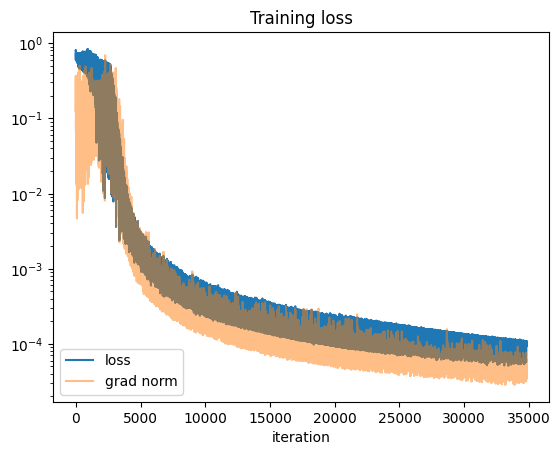

        X:  [1. 0. 0. 1. 1. 1. 0. 1. 0. 1.]
predicted:  [1. 1. 1. 0. 1. 0. 0. 1. 1. 0.]
   target:  [1. 1. 1. 0. 1. 0. 0. 1. 1. 0.]


In [ ]:
parity_net = ParityNet(hidden_dim=3)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
parity_trainer.lrate = 1e-2
losses = []
# When set to True the net recieves an error signal after each step
# When set to False the net recieves an error signal only once at the end
parity_trainer.full_supervision = True
# Gradient clipping
parity_trainer.max_grad_norm = 1.0
# This enables "curriculum learning" - we gradually train on
# longer and longer sequences
#
learning_curriculum = True
print("Training Loss with Full Supervision")
Tra_Loss_Full_Supervision = train_and_eval_parity(parity_trainer, learning_curriculum=learning_curriculum)

**Discussion:**

The graph depict the results of training a neural network to solve the parity problem, which involves predicting whether the number of ones in a sequence of binary digits is even or odd. The training process is iterative, gradually tweaking the network's parameters to improve its predictions.

Throughout training, two main metrics are tracked: the loss and the gradient norm. The loss measures how far the network's predictions are from the actual answers, with lower values indicating better performance. The gradient norm gives an idea of how much the network's parameters are changing with each update; large changes can indicate unstable learning, while very small changes might mean the learning has plateaued.

The training involves a "curriculum learning" approach, where the network starts by learning from shorter sequences and gradually takes on longer sequences as it improves. This can be likened to starting with simple problems and moving on to more complex ones as the learner's capability grows.

By the end of the training, the network is evaluated on its ability to predict the parity of a new sequence. The results show the network's predictions aligning with the actual answers, indicating that the network has learned the parity task successfully. In layman's terms, the network has become adept at counting the number of ones in a sequence and determining whether that count is even or odd, showcasing the effectiveness of the training process and the network's capability to generalize from what it has learned.

# Hyperparam analysis (P1, T2.3)

In [ ]:
# Modified train and eval parity for compared visualization
def train_and_eval_parity_mod(parity_trainer, patience_max=3, max_iters=100000, learning_curriculum=True, stop_loss=1e-4, max_seq_len = 100):

    seq_len = max_seq_len

    if learning_curriculum:
        seq_len = 10

    patience = patience_max

    losses = []

    for i in range(max_iters):
        Xp, Yp = gen_parity_examples(np.random.randint(1, seq_len), 10)
        ret = parity_trainer.train_step(Xp, Yp)

        losses.append(dict(iter=i, **ret))
        if ret['loss'] < stop_loss:
            patience -= 1
            if patience == 0:
                seq_len += 10
                if seq_len > max_seq_len:
                    break
                else:
                    patience = patience_max
        else:
            patience = patience_max

    losses_df = pd.DataFrame(losses)


    return losses_df

def evaluate_and_visualize_model(losses_df, parity_trainer, gen_parity_examples, np_to_tensor):
    # Plot the training loss and gradient norm
    plt.semilogy(losses_df['iter'], losses_df['loss'], label='loss')
    plt.semilogy(losses_df['iter'], losses_df['grad_norm'], label='grad norm', alpha=0.5)
    plt.legend(loc='lower left')
    plt.title('Training Loss and Gradient Norm')
    plt.xlabel('Iteration')
    plt.show()

    # Generate a set of examples to evaluate the model
    Xp, Yp = gen_parity_examples(10, 1)

    # Set the model to evaluation mode
    model = parity_trainer.network.eval()

    # Get predictions from the model
    predictions = model(np_to_tensor(Xp)).detach().cpu().numpy().squeeze()

    # Print the input sequence, the model's predictions, and the target values
    print('        X: ', Xp.squeeze())
    print('predicted: ', np.round(predictions))
    print('   target: ', Yp.squeeze())

 * **Training Loss with and without Full Supervision**

In [ ]:
import matplotlib.pyplot as plt

parity_net = ParityNet(hidden_dim=3)
if CUDA:
    parity_net.cuda()
parity_trainer_De = Trainer(parity_net)
parity_trainer.lrate = 1e-2
losses = []

# Initialize and configure parity trainers

parity_trainer_De.full_supervision = False  # Disable full supervision

# Gradient clipping
parity_trainer_De.max_grad_norm = 1.0

# Train both models and capture losses
print("Training Loss without Full Supervision")
Tra_Loss_Without_Full_Supervision = train_and_eval_parity_mod(parity_trainer_De, learning_curriculum=learning_curriculum);

Training Loss without Full Supervision


 * **Training Loss by changing Grad Max norm**

In [ ]:
parity_net = ParityNet(hidden_dim=3)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
parity_trainer.lrate = 1e-2
losses = []
# When set to True the net recieves an error signal after each step
# When set to False the net recieves an error signal only once at the end
parity_trainer.full_supervision = True

# set grad norm to 0.5 for Gradient clipping
parity_trainer.max_grad_norm = 0.5

learning_curriculum = True
print("Training Loss with varying Grad Max normo")
Tra_Loss_max_grad_norm_0_5 = train_and_eval_parity_mod(parity_trainer, learning_curriculum=learning_curriculum)

Training Loss with varying Grad Max normo


 * **Training Loss by changing Sequency length**

In [ ]:
parity_net = ParityNet(hidden_dim=3)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
parity_trainer.lrate = 1e-2
losses = []
# When set to True the net recieves an error signal after each step
# When set to False the net recieves an error signal only once at the end
parity_trainer.full_supervision = True
# Gradient clipping
parity_trainer.max_grad_norm = 1.0
# This enables "curriculum learning" - we gradually train on longer and longer sequences
# Set the maximum sequence length for training examples.
max_seq_len = 150
learning_curriculum = True
print("Training Loss with 150 maximum sequence length")
train_loss_max_seq_len_150 = train_and_eval_parity_mod(parity_trainer, learning_curriculum=learning_curriculum,max_seq_len = 150)

Training Loss with 150 maximum sequence length


Training Loss with Full Supervision


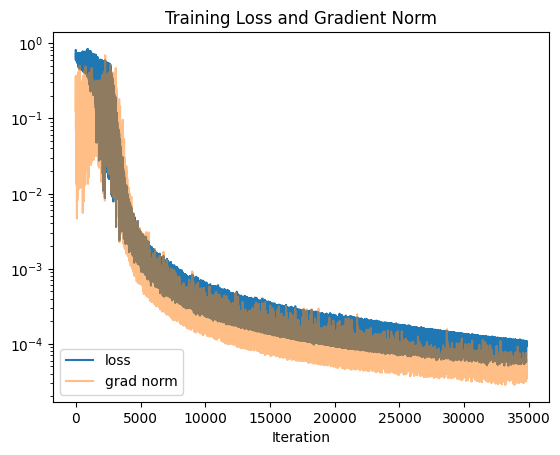

        X:  [0. 0. 0. 0. 1. 1. 1. 0. 1. 0.]
predicted:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
   target:  [0. 0. 0. 0. 1. 0. 1. 1. 0. 0.]
Training Loss without Full Supervision


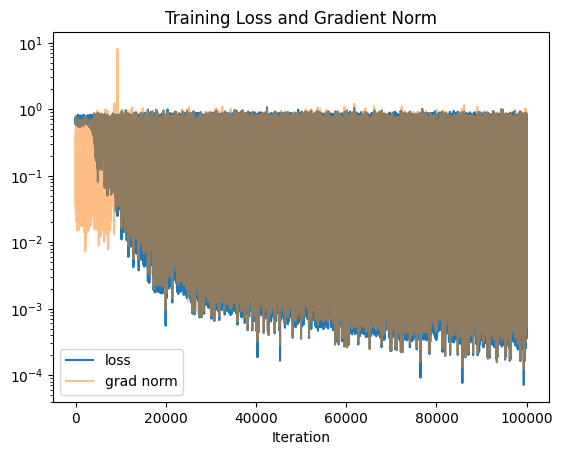

        X:  [1. 1. 0. 1. 0. 0. 0. 1. 1. 1.]
predicted:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   target:  [1. 0. 0. 1. 1. 1. 1. 0. 1. 0.]
Training Loss 1 Grad Max normo


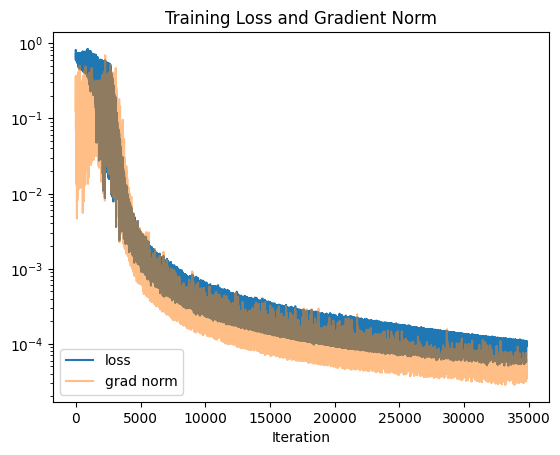

        X:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
predicted:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
   target:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
Training Loss 0.5 Grad Max normo


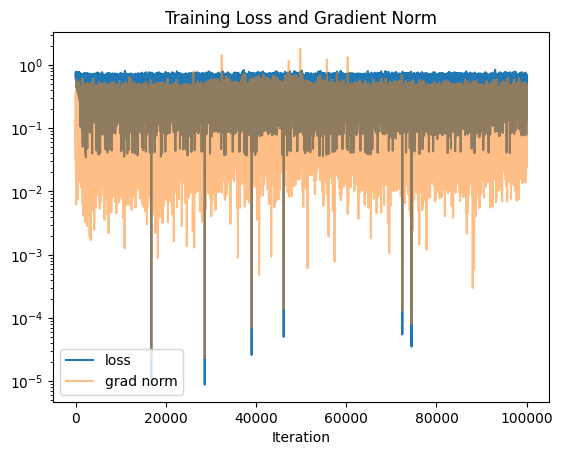

        X:  [0. 1. 0. 0. 1. 1. 0. 1. 1. 0.]
predicted:  [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
   target:  [0. 1. 1. 1. 0. 1. 1. 0. 1. 1.]
Training Loss with 150 maximum sequence length


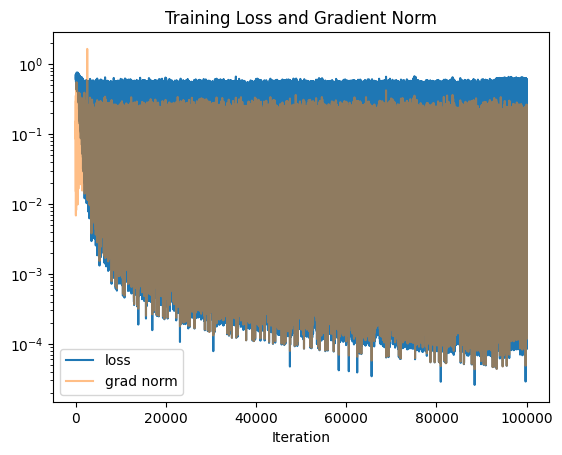

        X:  [0. 0. 0. 0. 0. 1. 0. 1. 0. 1.]
predicted:  [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
   target:  [0. 0. 0. 0. 0. 1. 1. 0. 0. 1.]


In [ ]:
print("Training Loss with Full Supervision")
evaluate_and_visualize_model(Tra_Loss_Full_Supervision, parity_trainer, gen_parity_examples, np_to_tensor)

print("Training Loss without Full Supervision")
evaluate_and_visualize_model(Tra_Loss_Without_Full_Supervision, parity_trainer, gen_parity_examples, np_to_tensor)

print("Training Loss 1 Grad Max normo")
evaluate_and_visualize_model(Tra_Loss_Full_Supervision, parity_trainer, gen_parity_examples, np_to_tensor)

print("Training Loss 0.5 Grad Max normo")
evaluate_and_visualize_model(Tra_Loss_max_grad_norm_0_5, parity_trainer, gen_parity_examples, np_to_tensor)

print("Training Loss with 150 maximum sequence length")
evaluate_and_visualize_model(train_loss_max_seq_len_150, parity_trainer, gen_parity_examples, np_to_tensor)


## LSTM

In [ ]:
class LSTMCell(nn.Module):
    def __init__(self, in_dim, hidden_dim, **kwargs):
        """
        Initialize the LSTMCell with input dimension and hidden dimension.

        Args:
            in_dim (int): The number of input features.
            hidden_dim (int): The number of features in the hidden state and cell state.
        """
        super(LSTMCell, self).__init__(**kwargs)
        # Linear transformation for input-to-gate connections
        self.in_to_gates = nn.Linear(in_dim, hidden_dim * 4, bias=True)
        # The output dimension is hidden_dim * 4 because an LSTM cell has four gates (input, forget, cell, and output), and each requires a vector of size hidden_dim.
        # Linear transformation for hidden-to-gate connections
        self.hidden_to_gates = nn.Linear(hidden_dim, hidden_dim * 4, bias=False)
        # . No bias is used here as it's already included in the in_to_gates layer

    def forward(self, input, hidden):
        """
        Forward pass of the LSTM cell to compute the next hidden state and cell state.

        Args:
            input (Tensor): The input tensor at the current time step.
            hidden (tuple): The tuple containing the previous hidden state and cell state.

        Returns:
            tuple: A tuple containing the next hidden state and cell state.
        """
        hx, cx = hidden  # Unpack the hidden and cell state from the previous time step
        gates = self.in_to_gates(input) + self.hidden_to_gates(hx)  # Calculate gate values

        # Split the concatenated gate values into individual gates
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        """# TODO TASK 3 #"""
        # Apply sigmoid activation to the input and forget gates
        # Apply sigmoid to the output gate
        # Apply tanh activation to the cell gate
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        outgate = torch.sigmoid(outgate)
        cellgate = torch.tanh(cellgate)

        # Compute the next cell state by combining the forget gate, input gate, and cell gate
        # The forget gate determines what to discard from the previous cell state
        # The input gate and cell gate determine what new information to add
        cy = (forgetgate * cx) + (ingate * cellgate)

        # Compute the next hidden state by applying the output gate to the tanh of the cell state
        hy = outgate * torch.tanh(cy)

        return hy, cy


0 {'loss': 0.7268085479736328, 'grad_norm': 0.15241388976573944}
500 {'loss': 0.07256758958101273, 'grad_norm': 0.045665886253118515}
1000 {'loss': 0.002014074707403779, 'grad_norm': 0.0015445981407538056}
1500 {'loss': 0.0007476838072761893, 'grad_norm': 0.0006165740196593106}
2000 {'loss': 0.0005565892206504941, 'grad_norm': 0.0006277078646235168}
2500 {'loss': 0.0003448684001341462, 'grad_norm': 0.0002798273926600814}
3000 {'loss': 0.00023605696333106607, 'grad_norm': 0.00018754479242488742}
3500 {'loss': 0.00020735042926389724, 'grad_norm': 0.00015925834304653108}
4000 {'loss': 0.00016031124687287956, 'grad_norm': 0.0001348220102954656}
4500 {'loss': 0.0001603195705683902, 'grad_norm': 0.00014063595153857023}
5000 {'loss': 0.0001423164940206334, 'grad_norm': 0.00010587026918074116}
5500 {'loss': 0.00011329183325869963, 'grad_norm': 9.02953979675658e-05}
5908 Increasing seq length to:  20
5942 Increasing seq length to:  30
5969 Increasing seq length to:  40
5991 Increasing seq lengt

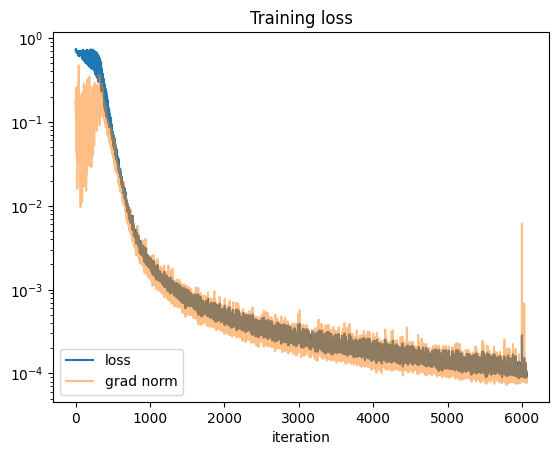

        X:  [0. 1. 0. 0. 0. 0. 1. 1. 0. 0.]
predicted:  [0. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
   target:  [0. 1. 1. 1. 1. 1. 0. 1. 1. 1.]


In [ ]:
parity_net = ParityNet(hidden_dim=3, use_lstm=True)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
losses = []
LSTM_Loss = train_and_eval_parity(parity_trainer, learning_curriculum=True)

**Discussion:**

Loss Function Trend: The loss function (in blue) shows a steep decline initially, indicating rapid learning and adjustment to the task. This is a positive sign that the LSTM is effectively capturing the dependencies in the sequence data.

Gradient Norm Fluctuations: The gradient norm (in orange) displays an initial spike, which is typical during the early training phase as the network parameters undergo significant updates. Following this, the gradient norm decreases and stabilizes, showing smaller fluctuations, which suggests the training is proceeding in a stable manner.

**LSTM With long sequences**

In [ ]:
parity_net = ParityNet(hidden_dim=3, use_lstm=True)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
losses = []
LSTM_Loss_max_seq_len_200  = train_and_eval_parity_mod(parity_trainer, learning_curriculum=True, max_seq_len = 200)

**Discussion:**
Loss Function Dynamics: The loss function (in blue) starts off high but decreases sharply, indicating that the LSTM is initially learning the patterns in the data quickly. However, unlike earlier graphs, the loss does not continue to decrease smoothly. Instead, it shows an upward trend followed by large variations. This could indicate that the LSTM is struggling to model the longer dependencies effectively.

Gradient Norm Fluctuations: The gradient norm (in orange) displays considerable variability, with numerous spikes throughout the training process. Such spikes could suggest that the LSTM is encountering difficulties in optimizing the loss function, which can be exacerbated by the increased sequence length, potentially causing instability in the learning process.

Sequence Length Impact: The annotation indicates that the sequence length has been increased to 200, which is relatively long and can present significant challenges for LSTMs due to issues like vanishing gradients. The fluctuations in the graph after this point suggest that the network's ability to learn from such long sequences might be limited with the current setup.

**RNN with long sequences**

In [ ]:
parity_net = ParityNet(hidden_dim=3)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
parity_trainer.lrate = 1e-2
losses = []
# When set to True the net recieves an error signal after each step
# When set to False the net recieves an error signal only once at the end
parity_trainer.full_supervision = False
# Gradient clipping
parity_trainer.max_grad_norm = 1
# This enables "curriculum learning" - we gradually train on
# longer and longer sequences
#
learning_curriculum = True
RNN_Loss_max_seq_len_200 = train_and_eval_parity_mod(parity_trainer, learning_curriculum=learning_curriculum, max_seq_len = 200)

**Discussion:**
Loss Function Behavior: Initially, there's a rapid decrease in the loss function (in blue), suggesting the RNN is learning effectively. As training progresses, the rate of decrease slows, and the loss begins to level off. This is common as the model approaches its performance limit given the current training conditions.

Gradient Norm Variability: The gradient norm (in orange) shows significant fluctuations in the early training phase, which is typical as the network navigates the steepest parts of the loss landscape. Over time, these fluctuations diminish, indicating the training is stabilizing.

Sequence Length and Learning Stability: The mention of "increasing seq length to: 200" suggests that the RNN is being subjected to longer input sequences as training progresses. The graph does not show a dramatic change in loss or gradient norm around the annotation, which could mean that the model is handling the increase without major issues.

# RNN vs LSTM on long sequences (P1, T4)

LSTM Loss max seq len 100


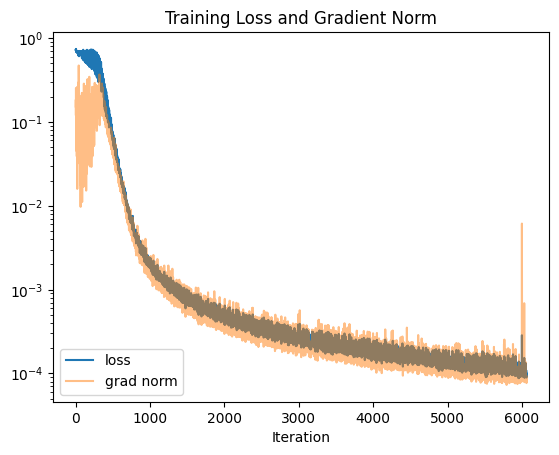

        X:  [1. 1. 0. 0. 1. 0. 1. 0. 1. 0.]
predicted:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   target:  [1. 0. 0. 0. 1. 1. 0. 0. 1. 1.]
LSTM Loss max seq len 200


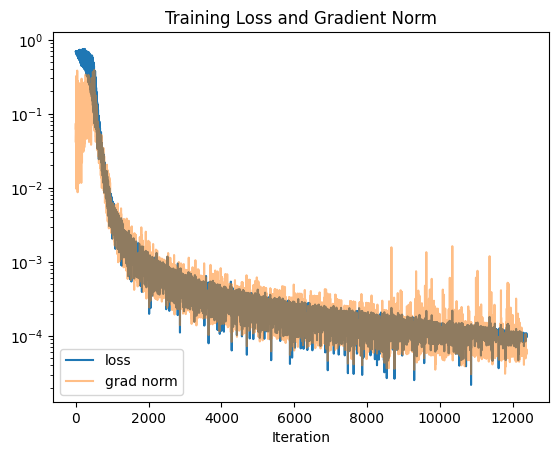

        X:  [0. 0. 1. 0. 1. 1. 0. 0. 0. 0.]
predicted:  [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
   target:  [0. 0. 1. 1. 0. 1. 1. 1. 1. 1.]
RNN Loss max seq len 150


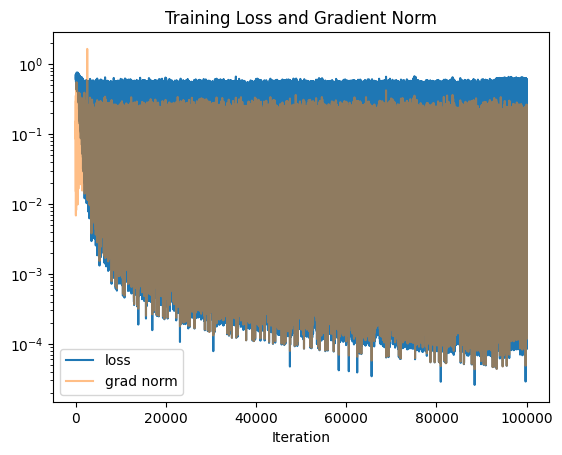

        X:  [1. 1. 0. 1. 0. 1. 1. 1. 0. 1.]
predicted:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   target:  [1. 0. 0. 1. 1. 0. 1. 0. 0. 1.]
RNN Loss max seq len 200


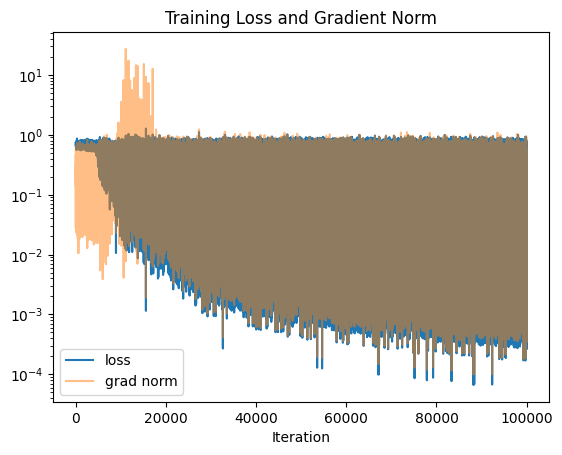

        X:  [1. 1. 1. 1. 0. 1. 1. 0. 0. 0.]
predicted:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   target:  [1. 0. 1. 0. 0. 1. 0. 0. 0. 0.]


In [ ]:
print('LSTM Loss max seq len 100')
evaluate_and_visualize_model(LSTM_Loss, parity_trainer, gen_parity_examples, np_to_tensor)
print('LSTM Loss max seq len 200')
evaluate_and_visualize_model(LSTM_Loss_max_seq_len_200, parity_trainer, gen_parity_examples, np_to_tensor)

print('RNN Loss max seq len 150')
evaluate_and_visualize_model(train_loss_max_seq_len_150, parity_trainer, gen_parity_examples, np_to_tensor)
print('RNN Loss max seq len 200')
evaluate_and_visualize_model(RNN_Loss_max_seq_len_200, parity_trainer, gen_parity_examples, np_to_tensor)


Training Loss with Full Supervision: This scenario assumes a dataset where each input is paired with a correct output (full supervision). Machine learning models under these conditions usually exhibit a training loss that rapidly decreases initially and then gradually flattens as the model approaches optimal performance. This is an ideal scenario for supervised learning tasks, where the model can leverage a complete set of labeled data to learn the underlying patterns.

Training Loss without Full Supervision: In contrast, training without full supervision—such as in semi-supervised or unsupervised learning—often results in a loss curve that does not decrease as predictably. The model has less direct information about the desired output and must infer structures or patterns without explicit guidance, which can lead to a slower and less steady decline in loss, or even a plateau if the model struggles to find structure in the data.

Training Loss by changing Grad Max norm: The term "Grad Max norm" likely refers to gradient clipping, a technique used to prevent exploding gradients by capping the maximum norm of the gradient vectors during backpropagation. Adjusting this parameter can significantly affect the training stability. Setting it too low may prevent the model from learning effectively, while too high a threshold might not mitigate the exploding gradients problem.

Training Loss by changing Sequence length: In sequence processing tasks (like natural language processing), the length of the input sequences can impact the model’s ability to learn. Short sequences may not provide enough context, while very long sequences can make learning difficult due to issues like vanishing gradients or increased computational complexity. Adjusting the sequence length can help find a balance between these extremes, optimizing the learning process.

Training Loss with 150 maximum sequence length: Setting a maximum sequence length to 150 might be specific to the constraints of the model or the computational resources. This can be a practical approach to standardize input size and manage memory usage. However, it could also mean that any input data longer than 150 tokens would be truncated, potentially losing valuable information. This constraint might be necessary for technical reasons but could also limit the model’s performance, especially if important contextual information lies beyond the 150-token limit.

# Problem 2. GPT

Now we will implement the GPT architecture. GPT stands for _Generative Pre-trained Transformer_. GPT is a model trained to generate sequences, one token (character, word, or else) at a time, pretty similar to the RNN from slide 25 in our lecture. GPT is the architecture behind the immensely famous [ChatGPT](https://chat.openai.com/) and many other state-of-the-art AIs.

GPT training examples look like this (image taken from [GPT-3 Illustrated](https://jalammar.github.io/how-gpt3-works-visualizations-animations/)):

![image.png](attachment:image.png)

So, in the example above, the input sequence would be `Second law of robotics: A robot must obey the orders given it by human`, and the target sequence would be `law of robotics: A robot must obey the orders given it by human beings`. In short words, GPT is a transformer trained to do next-token prediction. This is termed _auto-regressive modeling_.

Aside of the main transformer elements we saw in the lecture there are two extra things we need to take care of to implement GPT. First, a definition:

**Embedding**: a real valued vector of dimension $d$ (usually high-dimensional) representing something. E.g. neural nets can process numbers, but not words, so in order to get them to process text we assign an embedding to each word.

Now, two extra elements we need to implement:

1. **Positional encoding**:
    
    Notice how none of the operations in the transformer cares about the position of the elements in the sequence. The only operation by which elements of the sequence interact with each other is self-attention, but self-attention is just a weighted average of the sequence elements. In a weighted average if you change the order of the elements the result is still the same.
    
    Sequences however have an order. For instance, if we switch `robot` and `human` in the example above, yielding as input `Second law of robotics: A human must obey the orders given it by robot beings`, the meaning of the sentence has totally changed, but the output of the transformer would be the same as with the original!
    
    To fix this we need to somehow inject information about the position. The way we do it is by adding to each embedding representing an input word another embedding to represent the position of such word. Consider $E$ a function that assigns embeddings to words, and $P$ a function that assigns embeddings to positions. Then, in our example, the input to the transformer would be:
    
    $$
    E(Second) + P(0), E(law) + P(1), E(of) + P(2), \dots, E(human) + P(14)
    $$
    
    The simplest way to implement positional encoding is using learned embeddings: we assume that we will process sequences of at most $T$ elements, and initialize randomly $T$ positional embeddings. During training, the model learns to modify our randomly initialize embeddings to better represent position. There are however many [methods for positional encodings](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/). This is actually a fairly active research area. Currently, the most popular (advanced) positional encoding method is [RoPE](https://blog.eleuther.ai/rotary-embeddings/).



2. **Causal self-attention**:

    In self-attention, each embedding attends to itself and all of the other elements in the sequence. Therefore each token gets to see all of the other tokens in the sequence. This is a problem in GPT, where the task is next-token prediction. If a token gets to see all of the other tokens in the sequence, including the next token, then it can trivially solve the task by just copying the value of the next token to the output!
    
    We need to modify attention so that each token is only allowed to attend to itself and the previous tokens in the sequence:
    
    ![image-2.png](attachment:image-2.png)
    
    We do so by applying a mask to the attention matrix:
    
    ![image-3.png](attachment:image-3.png)
    
    ![image-4.png](attachment:image-4.png)
    
    ![image-5.png](attachment:image-5.png)
    

So, in summary, in GPT:

1. We convert each input token in the sequence to an embedding and add to it a positional embedding.
2. We pass the encoded inputs through $N$ transformer blocks, which are just as the ones we described in class, except that we use causal self-attention instead of vanilla self-attention.
3. We use the output of the last transformer block as the input to a Softmax classifier that predicts the next-token in the sequence.

In the tasks below you will implement and use the GPT architecture.


**Tasks**:
1. **(3.5 pt)** Implement a transformer decoder block:

    1.1 **(2 pt)** Implement the forward pass of `MultiheadAttention`. You should implement the projection of the input embeddings to queries, keys and values (using `c_attn`), the computation of the causal attention matrix, and the output projection (using `c_proj`).
    
    _Note_: notice that we intend to do the query, key, and value projections in a single batched operation, therefore the `3 * n_embd` as output in `c_attn`. This is a more efficient implementation than doing separate linear projections for query, key, and value. However, you can use separate projection matrices if it is easier for you.
    
    _Note_: for the causal attention matrix you can use [masked_fill](https://pytorch.org/docs/stable/generated/torch.Tensor.masked_fill_.html#torch.Tensor.masked_fill_) in order to apply the mask.
    
    1.2. **(0.5 pt)** Implement the forward pass of the attention block in `Block`. Use the following transformer block as guide of the operations you should implement:
    
    <div>
        <img src="attachment:image-6.png" width="200"/>
    </div>     
    
    Where `Norm` corresponds to layer normalization, i.e. `ln_1` and `ln_2` in our implementation.
    
    1.3. **(1 pt)** Implement the forward pass of the transformer in `GPT`. In here you should implement the operations that apply the token embedding `wte` and position embedding `wpe` to the inputs, as well as the stack of transformer blocks `h`.

2. **(7.0 pt max)** Train a GPT to learn to generate Harry Potter text based on the first four books:

    2.1 **(0.5 pt)** As we mentioned, neural nets need to assign vectors to words/characters in order to process them. Normally for that we use the [nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) module, as in the `__init__` method from `GPT`. It assigns vectors to integer numbers, which themselves can correspond to discrete symbols, like our characters or words. For this exercise you have to encode our text as integer numbers (we call this process tokenization). We will start with the simplest tokenization: encode each character as an integer. You will need to create two dictionaries: `stoi` (string to integer) and `itos` (integer to string) that map text to integers and integers to text, respectively.
    
    2.2 **(0.5 pt)** Define the targets `y` in the `get_batch` function so that the model does next token prediction.
    
    2.3 **(4.5 pt max)** Implement the code to generate data in the function `generate` of `GPT`. Here you just need to feed back the predicted next tokens that the model outputs as input for the next time step (**0.5 pt**). You can also implement [top-k sampling](https://huggingface.co/blog/how-to-generate) for an extra **1 pt**, and/or [Key-Value caching](https://huggingface.co/blog/optimize-llm) to accelerate inference for extra **3 pt**.
    
    2.4 **(1.5 pt)** Improve the tokenization.
    
    Using character tokenization is a simple first approach, but is rarely used in practice because it results in too long sequences (remember that the computational complexity of transformers grows quadratically with the sequence length). As an alternative we could split the text by whitespaces (e.g. the sentence _"said Dumbledore, smiling"_ becomes `["said", "Dumbledore,", "smiling"]`), and then encode each unique word in the text as an integer. This is termed word tokenization, and although it solves our issue with length, it comes with its own problems. For instance, how do we deal with a word that was not in the training set? We could assign an special token for unknown words, but there is a better alternative: subword tokenization.
    
    Subword tokenization divides words into smaller, meaningful units, from which other words can be formed. Consider the word "_chatGPT_", and imagine you are using a word-level tokenizer that doesn't recognize the term because it's not present in its vocabulary. In such a case, the entire term will be treated as an out-of-vocabulary (OOV) word, and the model may struggle to understand or generate meaningful predictions for it. A subword tokenizer, instead of treating the entire term as a single token, it would would break it down into smaller, more meaningful subword units. For instance, it might tokenize "_chatGPT_" into `chat` and `GPT`. This would enable the model to leverage its already acquired knowledge of `chat` and `GPT` to infer that likely "_chatGPT_" is a `GPT` with which you can `chat`.
    
    Implement subword tokenization. You can use [SentencePiece](https://github.com/google/sentencepiece) or any other subword tokenizer of your chosing. Repeat training. Do you see any improvement?.

3. **(2.5 pt máx)** Evaluate the English skills of your Harry Potter GPT.
    
    If you have successfully trained your GPT, you should have now a neural network that generates (vaguely) Harry Potter related text. How good of an English it learned from it? In this task we will assess it by calculating how well our model can tell apart proper and wrong English. We will test it in two problems:
    
    * Spelling test: we will present our model with pairs of `[word, non-word]`, e.g. `[observation, odservation]`. We will check on average how often our model assigns higher probablity to the properlly spelled word.
    * Grammar test: we will present our model with pairs of `[sentence, non-sentence]`, e.g. `[Hermione is listening to herself, Hermione is listening to itself]`. We will check on average how often our model assigns higher probablity to the properlly spelled sentence.
    
    In this exercise your task is to implement the function that will calculate the score of the model (**2 pt**). Remember from the lecture that we define the probability of a sentence of length $T$ composed of tokens $x_1, x_2, \dots, x_T$ as:
    
    $$
    p(x_1, x_2, \dots, x_T) = p(x_1)p(x_2 | x_1)p(x_3 | x_1, x_2) \dots p(x_T | x_1, x_2, \dots, x_{T-1})
    $$
    
   , and that our model's inputs and outputs look like this:
   
   <div>
        <img src="attachment:image.png" width="500"/>
    </div>
    
    _Hint: think of the equation for the cross entropy loss with which our model is trained, it should give you an easy answer_.
    
    For extra **0.5 pt**, and if you did task 2.4, check if a model trained on subwords does better on the grammar test.

In [ ]:

class MultiheadAttention(nn.Module): # it is  our custom module to perform multi-head attention.

    def __init__(self, n_embd, n_head, block_size, dropout):
        super().__init__()
        assert n_embd % n_head == 0, "The embedding dimension bust be divisible by the number of heads"
        self.n_head = n_head
        self.n_embd = n_embd
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(n_embd, 3 * n_embd, bias=False)
        # output projection to the original embedding dimension.
        self.c_proj = nn.Linear(n_embd, n_embd, bias=False)
        # regularization
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)
        # These define dropout layers for regularization: one is applied directly to the attention weights,
        # and the other is applied to the final output of the attention block (residual dropout).

    def forward(self, x):
        """
        Forward pass for the MultiheadAttention sublayer.

        Args:
            x (Tensor): Input tensor of shape (batch size, sequence length, embedding dimensionality).

        Returns:
            Tensor: Output tensor after applying multihead self-attention.
        """
        B, T, C = x.size()  #the dimensions of the input tensor x are unpacked.B batch size,T sequence length,C embedding size.
        # Calculate query, key, values for all heads in batch and split heads
        q,k,v = self.c_attn(x).chunk(3, dim=-1)

        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        """# TODO TASK 1.1 #"""
        # Scaled dot-product attention with causal masking
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        # The dot product of queries and keys is computed, and then scaled by the square root of the key's dimensionality.
        # This scaling helps with gradient stability.

        mask = torch.tril(torch.ones(T, T, dtype=torch.uint8, device=x.device)).view(1, 1, T, T)
        # A lower triangular matrix is created to use as a mask for causal attention. This ensures
        # that each token can only attend to previously seen tokens.

        att = att.masked_fill(mask == 0, float('-inf'))
        #The attention scores are masked so that future tokens are ignored by setting their values
        #to -inf which, after softmax, become zero.

        att = F.softmax(att, dim=-1)
        # A softmax function is applied to the masked attention scores to obtain the attention probabilities.

        att = self.attn_dropout(att)
        # Dropout is applied to the attention scores for regularization.

        # Compute attention output
        y = (att @ v).transpose(1, 2).contiguous().view(B, T, C)
        #The attention probabilities are used to weight the values. The result is transposed
        #back to the original shape and made contiguous.

        # Output projection
        y = self.c_proj(y)
        y = self.resid_dropout(y)
        return y


class MLP(nn.Module):

    def __init__(self, n_embd, dropout):
        super().__init__()
        self.c_fc    = nn.Linear(n_embd, 4 * n_embd, bias=False)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * n_embd, n_embd, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    # Ther two components are interspersed with layer normalization andwith layer normalization and include residual connections.

    def __init__(self, n_embd, n_head, block_size, dropout):
        super().__init__()
        self.ln_1 = nn.LayerNorm(n_embd)
        # Layer normalization is applied to stabilize the learning process by normalizing the input across the features.
        self.attn = MultiheadAttention(n_embd, n_head, block_size, dropout)
        self.ln_2 = nn.LayerNorm(n_embd)
        # This will be applied after the multi-head attention layer and before the feed-forward network.
        self.mlp = MLP(n_embd, dropout)

    def forward(self, x):
        """
        Forward pass for the Block sublayer, consisting of a transformer layer.

        Args:
            x (Tensor): Input tensor of shape (batch size, sequence length, embedding dimensionality).

        Returns:
            Tensor: Output tensor after processing with a transformer block.
        """

        """# TODO TASK 1.2 #"""
        x = x + self.attn(self.ln_1(x))  # Apply self-attention and add residual
        x = x + self.mlp(self.ln_2(x))   # Apply MLP and add residual
        return x





In [ ]:
class GPT(nn.Module):
    def __init__(self, n_layer, n_embd, n_head, block_size, vocab_size, dropout):
        super().__init__()
        self.block_size = block_size
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(vocab_size, n_embd),
            wpe = nn.Embedding(block_size, n_embd),
            drop = nn.Dropout(dropout),
            h = nn.ModuleList([Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)]),
            ln_f = nn.LayerNorm(n_embd),
        ))
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)
        # init all weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear) or isinstance(module, nn.LayerNorm):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)


    def forward(self, idx, targets=None):
        """
        Forward pass for the GPT model.

        Args:
        idx (LongTensor): Indices of input tokens (batch size, sequence length).
        targets (LongTensor, optional): Indices of target tokens (batch size, sequence length).

        Returns:
        Tuple[Tensor, Optional[Tensor]]: Logits for the next token prediction and optional loss if targets are provided.
        """
        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"


        """# TODO TASK 1.3"""
        # Implement the forward pass of the transformer

        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)

        pos = torch.arange(t, dtype=torch.long, device=device)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)

        #Prevents overfitting
        x = self.transformer.drop(tok_emb + pos_emb)
        # The token embeddings and position embeddings are added together and then passed through dropout.
        #This helps the model generalize better by preventing it from relying too much on any particular path through the model.

        for block in self.transformer.h:
        # Each block applies self-attention and a feedforward neural network to the data.
            x = block(x)
        x = self.transformer.ln_f(x)
        #the output is normalized using a layer normalization. This helps stabilize the learning process.

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate text given a starting sequence of indices.

        Args:
            idx (torch.Tensor): Starting token indices.
            max_new_tokens (int): Number of new tokens to generate.
            temperature (float): Temperature to use for sampling or A scaling factor for logits.
            top_k (int, optional): Top K tokens to be considered at each step.

        Returns:
            torch.Tensor: Tensor containing the indices of the generated tokens.
        """
        for _ in range(max_new_tokens): #The method loops over the number of new tokens to be generated
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]

            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature

            # Apply top-k filtering if specified
            if top_k is not None:
                """# TODO TASK 2.3"""
                topk_vals , indices = torch.topk(logits, top_k)
                logits = torch.full_like(logits, float('-inf'))
                logits.scatter_(1, indices, topk_vals)
            probs = F.softmax(logits, dim=-1)

            #If top-k filtering is applied, it restricts the model's choices to the top k logits. The logits are
            #then converted to probabilities using the softmax function.

            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

First we load our data containing the first four Harry Potter books:

In [ ]:
data = ""
for i in range(4):
    input_file_path = f"/kaggle/input/gpt-data/hp{i + 1}.txt"
    with open(input_file_path, 'r', encoding='latin-1') as f:
        book = f.read()
    data += book + "\n"
print(f"length of dataset in characters: {len(data):,}")


length of dataset in characters: 2,652,656


Here the first few lines of the text:

In [ ]:
print(data[:500])

Harry Potter and the Sorcerer's Stone


CHAPTER ONE

THE BOY WHO LIVED

Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say
that they were perfectly normal, thank you very much. They were the last
people you'd expect to be involved in anything strange or mysterious,
because they just didn't hold with such nonsense.

Mr. Dursley was the director of a firm called Grunnings, which made
drills. He was a big, beefy man with hardly any neck, although he did
have a very large mustache


We compute the vocabulary size, i.e. the number of unique tokens in our data. We are working at the character level, so we will count the number of unique characters:

In [ ]:
# get all the unique characters that occur in this text
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

all the unique characters: 	
 !"$%&'()*,-./0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ\]^_`abcdefghijklmnopqrstuvwxyz}~ü
vocab size: 91


Here you will integer encode the data. Define the two `dict` `stoi` and `itos` as described in the task 2.1. Afterwards we will split our data into train (first 90% of tokens) and validation (last 10% of tokens) sets

In [ ]:
"""# TODO TASK 2.1 #"""
# 'data' is a string containing all the text data
unique_chars = set(data)

# Create the mappings from characters to integers and integers to characters
stoi = {char: i for i, char in enumerate(unique_chars)} # Maps each unique character to a unique integer.
itos = {i: char for i, char in enumerate(unique_chars)} # Maps each unique integer back to its corresponding character.

def encode(s):
    """
    Encode a string into a list of integers.
    Args:
        s (str): The string to encode.
    Returns:
        list: The encoded list of integers representing the characters in the string.
    """
    return [stoi[c] for c in s]

def decode(l):
    """
    Decode a list of integers into a string.
    Args:
        l (list): The list of integers to decode.
    Returns:
        str: The decoded string.
    """
    return ''.join([itos[i] for i in l])

# Now, apply the encoding to the train and validation data splits
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

# Encode both train and validation data to integers
train_ids = encode(train_data)
val_ids = encode(val_data)

# Convert the encoded data to numpy arrays with type np.uint16
train_data = np.array(train_ids, dtype=np.uint16)
val_data = np.array(val_ids, dtype=np.uint16)

# Print out the number of tokens in train and validation sets
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

train has 2,387,390 tokens
val has 265,266 tokens


Here we define some variables regarding training and the model. You can play with them, however it all should work with these default values:

In [ ]:
CUDA = True
device = "cuda" if CUDA else "cpu"
# data
batch_size = 32
block_size = 256
# model
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.2
# adamw optimizer
learning_rate = 1e-3 # max learning rate
max_iters = 10000 # total number of training iterations
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
# learning rate decay settings
warmup_iters = 1000 # how many steps to warm up for
lr_decay_iters = max_iters
min_lr = 1e-4
# logging
eval_interval = 100
eval_iters = 10
log_interval = 10
# generation
max_new_tokens = 100
temperature = 0.8
top_k = 10 # Seting the top k value

We define the function that will sample training batches. Here you should define `y` so that the model is trained for next-token prediction:

In [ ]:
def get_batch(split):
    """
    Generate a batch of data for training or validation.

    Args:
        split (str): 'train' if fetching training data, 'val' for validation data.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: A tuple containing the input tensor `x` and the target tensor `y`.
    """
    # Select the correct data split
    data = train_data if split == 'train' else val_data

    # Randomly select starting indices for the sequences
    ix = torch.randint(len(data) - block_size, (batch_size,))

    # Create a batch of sequences that will be used as input
    x = torch.stack([torch.from_numpy(data[i:i+block_size].astype(np.int64)) for i in ix])

    """# TODO TASK 2.2 #"""
    # Define the targets that would implement next-token prediction
    y = torch.stack([torch.from_numpy(data[i+1:i+block_size+1].astype(np.int64)) for i in ix])
    # The target sequence is the input sequence shifted by one position to the right. This means each element
    # in the target sequence y is the next token that follows the corresponding element in the input sequence x.

    # Move tensors to the device set for training (GPU if CUDA is available)
    if device == 'cuda':
        # pin_memory() allows for faster data transfer to CUDA devices
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)

    return x, y


This function implements a learning rate schedule with a [warm-up phase and a cosine learning rate decay](https://residentmario.github.io/pytorch-training-performance-guide/lr-sched-and-optim.html#cosine-annealed-warm-restart). This turns out to be necessary to train transformer models.

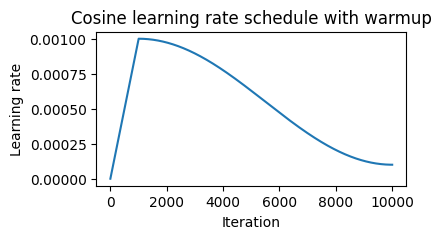

In [ ]:
# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

lr_seq = [get_lr(i) for i in range(max_iters)]
plt.figure(figsize=(4, 2))
plt.plot(lr_seq)
plt.title('Cosine learning rate schedule with warmup')
plt.xlabel('Iteration')
plt.ylabel('Learning rate')
plt.show()

For more details you can read [this post](https://www.borealisai.com/research-blogs/tutorial-17-transformers-iii-training/#Why_are_these_tricks_required).

In [ ]:
# We define the model
model = GPT(n_layer, n_embd, n_head, block_size, vocab_size, dropout)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# training loop
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
iter_num = 0 # number of iterations in the lifetime of this process
while True:
    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    # evaluate the loss on train/val sets
    if iter_num % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        start = " "
        start_ids = encode(start)
        x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
        # run generation
        model.eval()
        try:
            with torch.no_grad():
                y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
        except Exception as e:
            #pass # If you haven't implemented the generate code
            # If there's an error, print it out instead of ignoring it
            print(f"An error occurred during generation: {e}")
            y = None  # Explicitly set y to None to avoid NameError if used later
        model.train()
        # print('-' * 100)
        # print("Example generated:")
        # print('-' * 100)
        # print(decode(y[0].tolist()))
        # print('-' * 100)

        if y is not None:
            print("Example generated:")
            print('-' * 100)
            print(decode(y[0].tolist()))
            print('-' * 100)
        else:
            print("No example was generated due to an error.")
    logits, loss = model(X, Y)
    X, Y = get_batch('train')
    # clip the gradient
    if grad_clip != 0.0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0:
        lossf = loss.item() # loss as float. note: this is a CPU-GPU sync point
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms")
    iter_num += 1
    # termination conditions
    if iter_num > max_iters:
        break

step 0: train loss 4.5106, val loss 4.5106
Example generated:
----------------------------------------------------------------------------------------------------
 4]Pd]M=X?7^E*$HBK76]MUYoTqc;ü_ Xü(7K 4t"CBmMUpOy8Ee=0$e.NPW95aX!sK7Jxcj	pA};\Kjq
Xd7or(,7AyLHVKCM
----------------------------------------------------------------------------------------------------
iter 0: loss 4.5106, time 1685.52ms
iter 10: loss 4.5099, time 116.71ms
iter 20: loss 4.5067, time 135.53ms
iter 30: loss 4.5008, time 130.07ms
iter 40: loss 4.4871, time 136.33ms
iter 50: loss 4.4684, time 116.65ms
iter 60: loss 4.4526, time 117.12ms
iter 70: loss 4.4356, time 116.69ms
iter 80: loss 4.4147, time 117.24ms
iter 90: loss 4.3901, time 135.54ms
step 100: train loss 4.3530, val loss 4.3482
Example generated:
----------------------------------------------------------------------------------------------------
 doatdosan errlredi lrosirliindetrlsdddoarsi ats rita irasetl erereiirsioe tsdsrrlat seoniseit irsioo
-------

During the training of a GPT-like neural network model, the initial output typically consists of random and nonsensical text, reflecting the model's lack of understanding of language structure. As the training progresses, evidenced by decreasing loss values, the model incrementally learns from the data, adapting its internal parameters to recognize and predict language patterns more accurately. This learning process is reflected in the increasingly coherent and structured text generated over time, demonstrating the model's ability to assimilate and replicate the nuances of human language.

The application of top-K sampling is a strategic technique that enhances the model's text generation capabilities, especially in the early stages of training. By constraining the model's predictions to the K most likely next words, top-K sampling reduces randomness and guides the model towards more logical and contextually appropriate outputs. This method helps in producing text that is not only more coherent but also more aligned with the way humans naturally communicate, thereby improving the quality of the generated content even before the model has fully tuned its parameters to the intricacies of the language.

Here we define our model, optimizer, and run our training:

Now we will assess the English knowledge of our trained model (Task 3). We load the pairs of words and sentences and print some examples:

# With key-value caching

In [ ]:
class GPT(nn.Module):
    """
    A simplified GPT-like model for text generation.

    Attributes:
        block_size (int): The maximum length of the input tokens.
        transformer (nn.ModuleDict): A dictionary of transformer components including
                                     embeddings, dropout, and transformer blocks.
        lm_head (nn.Linear): The linear layer for language model prediction.

    Args:
        n_layer (int): The number of transformer blocks.
        n_embd (int): The dimensionality of embeddings.
        n_head (int): The number of attention heads in each transformer block.
        block_size (int): The maximum length of the input tokens.
        vocab_size (int): The size of the vocabulary.
        dropout (float): Dropout rate.
    """

    def __init__(self, n_layer, n_embd, n_head, block_size, vocab_size, dropout):
        super().__init__()
        self.block_size = block_size
        # Initialize transformer components
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(vocab_size, n_embd), # Word token embeddings
            wpe = nn.Embedding(block_size, n_embd), # Positional embeddings
            drop = nn.Dropout(dropout),             # Dropout layer
            h = nn.ModuleList([Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)]),  # Transformer blocks
            ln_f = nn.LayerNorm(n_embd),            # Layer normalization
        ))
        # The output head for language model prediction
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)

        # Initialize weights of the model
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """
        Initializes weights of the model.

        Args:
            module (nn.Module): A module of the neural network.
        """
        if isinstance(module, nn.Linear) or isinstance(module, nn.LayerNorm):
            # Initialize linear and normalization layers
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            # Initialize embeddings
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        """
        Forward pass through the GPT model.

        Args:
            idx (torch.Tensor): Input token indices.
            targets (torch.Tensor, optional): Target token indices for training.

        Returns:
            tuple: A tuple containing the logits and, if provided, the loss.
        """
        device = idx.device
        b, t = idx.size()
        # Ensure input length is within the block size
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"

        # Compute token and position embeddings
        tok_emb = self.transformer.wte(idx)  # Token embeddings
        pos = torch.arange(t, device=device)  # Position indices
        pos_emb = self.transformer.wpe(pos)[None, :, :]  # Position embeddings
        x = self.transformer.drop(tok_emb + pos_emb)  # Sum and apply dropout

        # Pass through each transformer block
        for block in self.transformer.h:
            x = block(x)

        # Apply final layer normalization
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            # Compute logits and loss if targets are provided
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
      """
        Generate text using the model.

        Args:
            idx (torch.Tensor): Input token indices.
            max_new_tokens (int): The maximum number of new tokens to generate.
            temperature (float): Sampling temperature for token generation.
            top_k (int, optional): The number of top tokens considered for sampling.

        Returns:
            torch.Tensor: Generated token indices.
        """
      cache = [None] * len(self.transformer.h)  # Initialize cache for each layer

      for _ in range(max_new_tokens):
          # Prepare the token embeddings and positional encodings
          x = self.transformer.wte(idx)  # Token embeddings
          pos = torch.arange(idx.size(-1), device=idx.device)  # Positional encodings
          x = x + self.transformer.wpe(pos)[None, :, :]  # Add token and position embeddings
          x = self.transformer.drop(x)

          # Pass through each transformer block with caching
          for i, block in enumerate(self.transformer.h):
              x_attn = block.ln_1(x)
              x_attn, present = block.attn(x_attn, layer_past=cache[i])
              cache[i] = present  # Update the cache with the current key-value pairs
              x = x_attn + x  # Apply attention and add residual
              x = block.ln_2(x)
              x = block.mlp(x) + x  # Apply MLP and add residual

              x = self.transformer.ln_f(x)

          # Compute logits and apply temperature
          logits = self.lm_head(x)[:, -1, :] / temperature

          # Optionally crop logits to only the top k options
          if top_k is not None:
              top_logits, top_indices = torch.topk(logits, top_k)
              probs = F.softmax(top_logits, dim=-1)
              idx_next = torch.multinomial(probs, num_samples=1)
              idx_next = torch.gather(top_indices, -1, idx_next)
          else:
              probs = F.softmax(logits, dim=-1)
              idx_next = torch.multinomial(probs, num_samples=1)

            # Append sampled index to the running sequence and continue
          idx = torch.cat([idx, idx_next], dim=1)

            # If the sequence context is growing too long, crop it at block_size
          if idx.size(1) > self.block_size:
              idx = idx[:, -self.block_size:]

      return idx

In [ ]:
# We define the model
model = GPT(n_layer, n_embd, n_head, block_size, vocab_size, dropout)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# training loop
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
iter_num = 0 # number of iterations in the lifetime of this process
while True:
    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    # evaluate the loss on train/val sets
    if iter_num % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        start = " "
        start_ids = encode(start)
        x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
        # run generation
        model.eval()
        try:
            with torch.no_grad():
                y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
        except Exception as e:
            #pass # If you haven't implemented the generate code
            # If there's an error, print it out instead of ignoring it
            print(f"An error occurred during generation: {e}")
            y = None  # Explicitly set y to None to avoid NameError if used later
        model.train()
        # print('-' * 100)
        # print("Example generated:")
        # print('-' * 100)
        # print(decode(y[0].tolist()))
        # print('-' * 100)

        if y is not None:
            print("Example generated:")
            print('-' * 100)
            print(decode(y[0].tolist()))
            print('-' * 100)
        else:
            print("No example was generated due to an error.")
    logits, loss = model(X, Y)
    X, Y = get_batch('train')
    # clip the gradient
    if grad_clip != 0.0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0:
        lossf = loss.item() # loss as float. note: this is a CPU-GPU sync point
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms")
    iter_num += 1
    # termination conditions
    if iter_num > max_iters:
        break

step 0: train loss 4.5113, val loss 4.5113
An error occurred during generation: MultiheadAttention.forward() got an unexpected keyword argument 'layer_past'
No example was generated due to an error.
iter 0: loss 4.5112, time 1042.68ms
iter 10: loss 4.5105, time 145.86ms
iter 20: loss 4.5080, time 116.52ms
iter 30: loss 4.5026, time 134.93ms
iter 40: loss 4.4906, time 133.83ms
iter 50: loss 4.4729, time 131.02ms
iter 60: loss 4.4594, time 134.83ms
iter 70: loss 4.4425, time 120.86ms
iter 80: loss 4.4241, time 133.78ms
iter 90: loss 4.3979, time 134.08ms
step 100: train loss 4.3632, val loss 4.3596
An error occurred during generation: MultiheadAttention.forward() got an unexpected keyword argument 'layer_past'
No example was generated due to an error.
iter 100: loss 4.3642, time 963.06ms
iter 110: loss 4.3216, time 116.83ms
iter 120: loss 4.2741, time 116.49ms
iter 130: loss 4.2101, time 116.44ms
iter 140: loss 4.1354, time 116.46ms
iter 150: loss 4.0495, time 171.98ms
iter 160: loss 3.9

Top-k sampling narrows down word choices to the most likely ones, which significantly enhances the clarity and overall quality of the text, especially during the initial stages of training. On the other hand, key value caching plays a crucial role in the efficiency of transformer models. It saves key and value pairs that were calculated before, which cuts down on repeated calculations. This is especially useful for long sequences. So, while top-k sampling makes the output better, key value caching helps the system work faster, which is important for complex tasks.

# Grammer and Spelling Check

In [ ]:
with open("/kaggle/input/gpt-data/wuggy.txt", 'r') as f:
    spelling_samples = [sample[:-1].split(',') for sample in f]
with open("/kaggle/input/gpt-data/blimp.txt", 'r') as f:
    grammar_test_samples = [sample[:-1].split(',') for sample in f]
print(spelling_samples[0])
print(grammar_test_samples[0])

['objectivity', 'osbrectifity']
["Harry hadn't attacked himself", "Harry hadn't attacked herself"]


In [ ]:

def get_sample_prob(X):
    """
    Calculates the probability of the last token in the sequence X using the pre-trained model.

    Args:
        X (torch.Tensor): The tokenized input sequence.

    Returns:
        float: Probability of the last token in the sequence.
    """

    """# TODO TASK 3 #"""
    logits, _ = model(X[:, :-1])
    log_probs = F.log_softmax(logits, dim=-1)

    targets = X[:, 1:]  # The targets are the tokens shifted by one position

    gathered_log_probs = torch.gather(log_probs, 2, targets.unsqueeze(1)).squeeze(2)
    # print(gathered_log_probs.shape)
    # Sum the log probabilities for the entire sequence
    sequence_log_prob = gathered_log_probs.sum()
    return torch.tensor(sequence_log_prob).cpu().detach()

spelling_scores = []
for sample in tqdm(spelling_samples):
    word, non_word = sample
    tokenized_word = torch.tensor(encode(word)).unsqueeze(0).to(device)
    prob_word = get_sample_prob(tokenized_word)
    tokenized_non_word = torch.tensor(encode(non_word)).unsqueeze(0).to(device)
    prob_non_word = get_sample_prob(tokenized_non_word)
    spelling_scores.append(1.0 * (prob_word > prob_non_word))

print("Spelling score: ", np.mean(spelling_scores))

grammar_scores = []
for sample in tqdm(grammar_test_samples):
    sentence, non_sentence = sample
    tokenized_sentence = torch.tensor(encode(sentence)).unsqueeze(0).to(device)
    prob_sentence = get_sample_prob(tokenized_sentence)
    tokenized_non_sentence = torch.tensor(encode(non_sentence)).unsqueeze(0).to(device)
    prob_non_sentence = get_sample_prob(tokenized_non_sentence)
    grammar_scores.append(1.0 * (prob_sentence > prob_non_sentence))

print("Grammar score: ", np.mean(grammar_scores))


  0%|          | 0/40000 [00:00<?, ?it/s]/tmp/ipykernel_1788/1759999381.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sequence_log_prob).cpu().detach()
100%|██████████| 40000/40000 [09:18<00:00, 71.61it/s]


Spelling score:  0.515975


100%|██████████| 500/500 [00:07<00:00, 65.49it/s]

Grammar score:  0.512


# Grammer and Spelling check for Tokenizer

In [ ]:
# Initialize the GPT model with specified parameters
model_sub = GPT(n_layer, n_embd, n_head, block_size, vocab_size=2000, dropout=dropout)
# Move the model to the specified computing device (e.g., GPU or CPU)
model_sub.to(device)

def get_sample_prob(tokenized_input):
    """
    Calculates the probability of the last token in the tokenized input sequence.

    Args:
        tokenized_input (list of int): Tokenized input sequence.

    Returns:
        float: Probability of the last token in the sequence.
    """
    X = torch.tensor(tokenized_input).to(device)
    model_sub.eval()
    with torch.no_grad():
        logits, _ = model_sub(X.unsqueeze(0))
        probabilities = F.softmax(logits[:, -1, :], dim=-1)
        prob_last_token = probabilities[0, X[-1].item()].item()
    return prob_last_token

def calculate_score(samples, encode_func):
    """
    Calculates the average score by comparing the probabilities of correct and incorrect sequences.

    Args:
        samples (list of tuples): List of tuples containing correct and incorrect sequences.
        encode_func (function): Function to tokenize the sequences.

    Returns:
        float: Average score calculated from the samples.
    """
    scores = []
    for correct, incorrect in tqdm(samples):
        prob_correct = get_sample_prob(encode_func(correct))
        prob_incorrect = get_sample_prob(encode_func(incorrect))
        scores.append(1.0 * (prob_correct > prob_incorrect))
    return np.mean(scores)

# Calculate spelling and grammar scores
spelling_score = calculate_score(spelling_samples, encode)
grammar_score = calculate_score(grammar_test_samples, encode)

# Print results
print("Spelling score: ", spelling_score)
print("Grammar score: ", grammar_score)


100%|██████████| 500/500 [00:05<00:00, 91.32it/s] 

Spelling score:  0.500125
Grammar score:  0.598


# Problem 3. Vision transformer

Transformers go well beyond text. They have been applied with tremendous success to many modalities (audio, images, video, graphs, etc). However, its application to images can be unintuitive, as we do not tend to think of them as the 1D sequences for which transformers were designed. In this exercise we will implement a vision transformer to illustrate how this works.

We use the classic MNIST dataset and will try to get a vision transformer to do classification of handwritten numbers.

In [ ]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

Let's take a look at one of the samples:

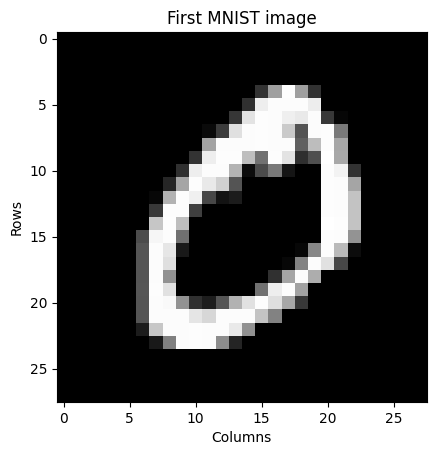

In [ ]:
first_image = np.array(mnist_trainset[1][0])
plt.imshow(first_image, cmap='gray')
plt.title('First MNIST image')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

The way we turn an image into a 1D sequence is pretty straightforward. We can simply flatten it in a row major form. That is, we will turn our 28x28 pixels image into a 784 long sequence, with the first row becoming the first 24 elements, the second row the next, and so on.

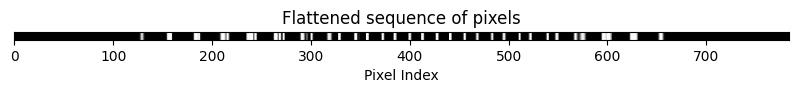

In [ ]:
flattened_image = first_image.reshape(-1) # reshapes it into a 1D array
plt.figure(figsize=(10, 0.1))
plt.imshow([flattened_image], cmap='gray', aspect='auto')
plt.title('Flattened sequence of pixels')
plt.xlabel('Pixel Index')
plt.yticks([])
plt.show()

This should work fine, but there is a technical issue. Remember that transformer's computational cost scales quadratically with the length of the sequence. Notice that our tiny 24x24 pixels image already results in a sequence of length 784. This is ok as long as you have a moderately large GPU and you use a not too large batch size, but in Colab, or in the smallest GPUs in our cluster we might already run into memory issues. Moreover, in most practical applications we will be dealing with much larger images. For a standard HD image of 1024 x 768 pixels we would have a sequence length of 786432! This is already almost 10 times more than what the state-of-the-art models like GPT-4 support.

In practice, instead of working on sequences of pixels, we use sequences of image patches. We will split our image into non-overlapping 4x4 patches:

Text(0.5, 1.0, 'Image with 4x4 Patches')

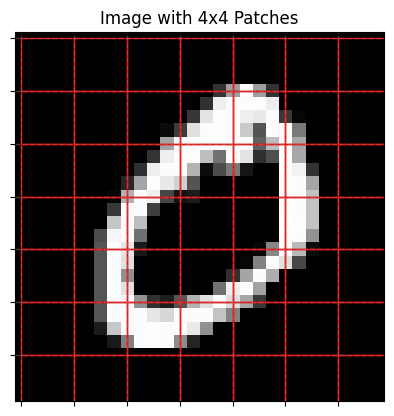

In [ ]:
image_size = first_image.shape[0]
patch_size = 4
fig, ax = plt.subplots()
ax.imshow(first_image, cmap='gray')
for i in range(0, image_size, patch_size):
    for j in range(0, image_size, patch_size):
        rect = Rectangle((j, i), patch_size, patch_size, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
ax.set_xticks(np.arange(0, image_size, patch_size))
ax.set_yticks(np.arange(0, image_size, patch_size))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(True, which='both', linestyle='--', linewidth=1, color='gray', alpha=0.5)
plt.title(f'Image with {patch_size}x{patch_size} Patches')

When we flattened it, it becomes a sequence of 49 patches:

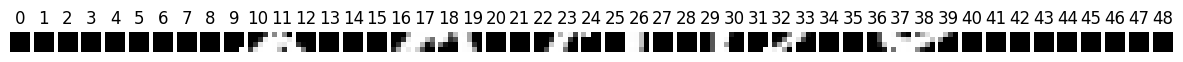

In [ ]:
patch_sequence = []
for i in range(0, image_size, patch_size):
    for j in range(0, image_size, patch_size):
        patch = first_image[i:i+patch_size, j:j+patch_size]
        patch_sequence.append(patch)
num_patches = (image_size // patch_size) ** 2
fig, axs = plt.subplots(1, num_patches, figsize=(15, 2))
for i, patch in enumerate(patch_sequence):
    axs[i].imshow(patch, cmap='gray')
    axs[i].set_title(i)
    axs[i].axis('off')

plt.show()

_Note: in most practical applications we will be dealing with much larger images, so we will need larger patches in order to sufficiently shorten the sequence length._


Finally we transform each patch, a 4x4 matrix, into a vector of 16 elements, which is the input our transformer expects. We simply flatten each patch:

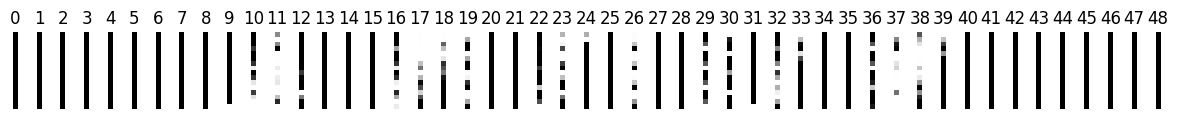

In [ ]:
fig, axs = plt.subplots(1, num_patches, figsize=(15, 1))
for i, patch in enumerate(patch_sequence):
    axs[i].imshow(patch.reshape(-1, 1), cmap='gray')
    axs[i].set_title(i)
    axs[i].axis('off')
plt.show()

We have our inputs ready. Now onto the model. This is the architecture our digit classifier will use:
    
  <div>
        <img src="attachment:image.png" width="500"/>
    </div>

**Tasks**:
1. **(3 pt)** Implement the architecture of the classifier in the class `VisionTransformer` and train it on the MNIST dataset. Note that you can reuse most of the elements that you already implemented for `GPT`. You just need to avoid auto-regressive masking and figure out how to input the patches instead of discrete tokens.
2. **(2 pt)** Implement a simple convolutional network classifier and compare its performnace with the vision transformer.
3. **(4 pt máx)** Implement any of the two methods from the paper [Vision Transformer for Small-Size Datasets](https://arxiv.org/pdf/2112.13492v1.pdf) to try to improve the performance of our model. You can find a Keras tutorial implementing them [here](https://keras.io/examples/vision/vit_small_ds/#implement-locality-self-attention). Each method is worth **2 pt**.

Let's start defining some parameters. As before, it works with these defaults, but you can play with them

In [ ]:
# Load the MNIST dataset for training. 'root' specifies the directory to store the data,
# 'train=True' indicates loading the training set, 'download=True' enables downloading the data if not present locally,
# and 'transform=None' means no image transformations are applied.
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

# Load the MNIST dataset for testing. Similar parameters as above, but 'train=False' loads the test set.
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

# Determine the computing device: use CUDA if available ('cuda'), otherwise use the CPU ('cpu').
device = "cuda" if CUDA else "cpu"

# Data configuration:
# 'batch_size' specifies the number of samples processed before the model is updated.
batch_size = 32
# 'patch_size' defines the size of the patches to be extracted from the input images.
patch_size = 4
# Calculate the width and height of the images in the dataset.
img_w, img_h = np.array(mnist_trainset[1][0]).shape
# Calculate the total number of blocks in each image based on the patch size.
block_size = img_w // patch_size * img_h // patch_size

# Model configuration:
# 'n_layer' defines the number of layers in the neural network.
n_layer = 6
# 'n_head' specifies the number of attention heads in each layer.
n_head = 6
# 'n_embd' sets the dimensionality of the embeddings.
n_embd = 384
# 'dropout' is the dropout rate for regularization to prevent overfitting.
dropout = 0.2
# 'input_size' represents the size of each input to the model.
input_size = patch_size * patch_size
# 'n_classes' is the number of output classes, which is 10 for digit classification (0-9).
n_classes = 10

# AdamW optimizer configuration:
# 'learning_rate' sets the initial learning rate for the optimizer.
learning_rate = 5e-4
# 'max_iters' defines the total number of training iterations.
max_iters = 10000
# 'grad_clip' is the value to clip the gradients during training, or disables clipping if set to 0.0.
grad_clip = 1.0

# Learning rate decay settings:
# 'warmup_iters' specifies the number of iterations for the learning rate warm-up phase.
warmup_iters = 1000
# 'lr_decay_iters' sets the number of iterations over which to decay the learning rate.
lr_decay_iters = max_iters
# 'min_lr' is the minimum learning rate after decay.
min_lr = 5e-5

# Logging configuration:
# 'eval_interval' sets how often to evaluate the model on the test set.
eval_interval = 1000
# 'log_interval' determines how often to log training information.
log_interval = 100


Now we preprocess our dataset to transform every image into patch sequences of shape `(49, patch_size, patch_size)`

In [ ]:
# Transformation to extract patches and flatten them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)),
    transforms.Lambda(lambda x: x.contiguous().view(-1, patch_size, patch_size)),
])

# Apply the transform to the loaded datasets
mnist_trainset.transform = transform
mnist_testset.transform = transform

Here you have to define the model:

In [ ]:

class VisionTransformer(nn.Module):
    def __init__(self, input_size, n_classes, n_layer, n_embd, n_head, block_size, dropout):
        super().__init__()

        """# TODO TASK 1 #"""
        self.block_size = block_size

        self.block_size = block_size

        # Define the transformer components
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Linear(input_size, n_embd),  # Linear layer for patch embedding
            wpe=nn.Embedding(block_size, n_embd),  # Positional embedding layer
            drop=nn.Dropout(dropout), # Dropout layer
            h=nn.ModuleList([Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)]),  # Transformer blocks
            ln_f=nn.LayerNorm(n_embd),  # Layer normalization
        ))

        # Classifier head
        self.classifier = nn.Linear(n_embd, n_classes)
        # init weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        # Initialize weights
        if isinstance(module, nn.Linear) or isinstance(module, nn.LayerNorm):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x, targets=None):
        device = x.device
        b, t = x.size(0), x.size(1)
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"

        """# TODO TASK 1 #"""
        # Compute patch embeddings and add positional encodings
        x = self.transformer.wte(x)  # Patch embeddings
        pos = torch.arange(t, device=device)  # Position indices
        x = x + self.transformer.wpe(pos)[None, :, :]  # Add positional embeddings
        x = self.transformer.drop(x)  # Apply dropout

        # Pass through each transformer block
        for block in self.transformer.h:
            x = block(x)

        # Apply final layer normalization
        x = self.transformer.ln_f(x)

        # Classifier head
        # Mean pooling is used before the classification layer
        logits = self.classifier(x.mean(dim=1))  # Using mean pooling here

        # Compute loss if targets are provided
        loss = F.cross_entropy(logits, targets) if targets is not None else None
        return logits, loss


This code is to implement a Vision Transformer model for image classification tasks. This type of model leverages the transformer's ability to handle long-range dependencies, making it effective for tasks where understanding the global context of an image is crucial. The architecture is modular and can be adapted for different image sizes and complexities. The inclusion of dropout and layer normalization are standard techniques to enhance model generalization and stability during training.

In [ ]:
# Create data loaders
train_loader = DataLoader(dataset=mnist_trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=mnist_testset, batch_size=batch_size, shuffle=False)

# Model
model = VisionTransformer(input_size, n_classes, n_layer, n_embd, n_head, block_size, dropout)
model.to(device)
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

iter_counter = 0
vit_losses = []  # List to store test losses for Vision Transformer
vit_accuracy = [] # List to store accuracy metrics

while iter_counter < max_iters:
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # Flatten the patch
        patch_sequence = data.view(-1, block_size, patch_size * patch_size).to(device)
        target = target.to(device)
        # Forward pass
        logits, loss = model(patch_sequence, target)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Calculate accuracy
        _, predicted = torch.max(logits, -1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        total_loss += loss.item()
        iter_counter += 1
        # Log loss and accuracy
        if iter_counter % log_interval == 0:
            avg_loss = total_loss / log_interval
            accuracy = correct / total
            print(f'Iter [{iter_counter}/{max_iters}], Batch [{batch_idx+1}/{len(train_loader)}], '
                  f'Loss: {avg_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')
            total_loss = 0.0
            correct = 0
            total = 0
        # Evaluate test loss
        if iter_counter % eval_interval == 0 or iter_counter == max_iters:
            model.eval()
            test_loss = 0.0
            test_correct = 0
            test_total = 0
            with torch.no_grad():
                for test_data, test_target in test_loader:
                    test_patch_sequence = test_data.view(-1, block_size, patch_size * patch_size).to(device)
                    test_target = test_target.to(device)
                    test_outputs, loss = model(test_patch_sequence, test_target)
                    test_loss += loss.item()
                    vit_losses.append(loss.item())
                    _, test_predicted = torch.max(test_outputs, -1)
                    test_total += test_target.size(0)
                    test_correct += (test_predicted == test_target).sum().item()

            avg_test_loss = test_loss / len(test_loader)
            test_accuracy = test_correct / test_total
            vit_accuracy.append(test_accuracy)

            print(f'Iter [{iter_counter}/{max_iters}], Batch [{batch_idx+1}/{len(train_loader)}], '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')
            model.train()
        if iter_counter == max_iters:
            break

Iter [100/10000], Batch [100/1875], Loss: 2.2283, Accuracy: 17.97%
Iter [200/10000], Batch [200/1875], Loss: 1.9808, Accuracy: 26.78%
Iter [300/10000], Batch [300/1875], Loss: 1.8040, Accuracy: 34.34%
Iter [400/10000], Batch [400/1875], Loss: 1.7744, Accuracy: 33.84%
Iter [500/10000], Batch [500/1875], Loss: 1.6178, Accuracy: 38.69%
Iter [600/10000], Batch [600/1875], Loss: 1.5778, Accuracy: 42.78%
Iter [700/10000], Batch [700/1875], Loss: 1.5616, Accuracy: 43.41%
Iter [800/10000], Batch [800/1875], Loss: 1.5688, Accuracy: 43.84%
Iter [900/10000], Batch [900/1875], Loss: 1.5133, Accuracy: 42.12%
Iter [1000/10000], Batch [1000/1875], Loss: 1.5126, Accuracy: 43.78%
Iter [1000/10000], Batch [1000/1875], Test Loss: 1.4787, Test Accuracy: 44.01%
Iter [1100/10000], Batch [1100/1875], Loss: 1.4544, Accuracy: 48.72%
Iter [1200/10000], Batch [1200/1875], Loss: 1.4035, Accuracy: 49.75%
Iter [1300/10000], Batch [1300/1875], Loss: 1.3324, Accuracy: 52.84%
Iter [1400/10000], Batch [1400/1875], Loss

**1. Define the CNN Architecture**

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(dataset=mnist_trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=mnist_testset, batch_size=batch_size, shuffle=False)


In [ ]:
class SimpleCNN(torch.nn.Module):
    def __init__(self, n_classes):
        """
        Initializes the SimpleCNN model.

        Args:
            n_classes (int): The number of classes for the classification task.
        """
        super().__init__()
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), # 32 filters, 3x3 kernel, stride 1, padding 1
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling layer with 2x2 kernel, stride 2

            # Second convolutional layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 64 filters, 3x3 kernel, stride 1, padding 1
            nn.ReLU(),  # Activation function
            nn.MaxPool2d(kernel_size=2, stride=2) # Max pooling layer with 2x2 kernel, stride 2
        )

        # Fully connected (dense) layers
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 1024),  # Linear layer with 1024 output features
            nn.ReLU(),  # Activation function
            nn.Dropout(0.5),  # Dropout layer with 50% probability
            nn.Linear(1024, n_classes)  # Final linear layer with output size equal to the number of classes
        )

    def forward(self, x):
        """
        Forward pass of the SimpleCNN.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying log softmax.
        """
        x = self.conv_layers(x) # Apply convolutional layers
        x = x.view(x.size(0), -1)  # Flatten the output for the dense layers
        x = self.fc_layers(x) # Apply fully connected layers
        return F.log_softmax(x, dim=1)  # Apply log softmax to the output

**2. Train the Model**

In [ ]:
def train(model, device, train_loader, optimizer, max_iters, log_interval):
    model.train() # Set the model to training mode
    total_loss = 0  # Total loss for all batches
    correct = 0 # Total number of correct predictions
    total = 0 # Total number of processed samples
    iter_counter = 0  # Count the number of iterations

    while iter_counter < max_iters:
        for batch_idx, (data, target) in enumerate(train_loader):
            if iter_counter >= max_iters:
                break

            # Move data to the specified device (e.g., GPU)
            data, target = data.to(device), target.to(device)
            # Reset gradients
            optimizer.zero_grad()
            # Forward pass: compute the model output
            output = model(data)
            # Compute the loss
            loss = F.nll_loss(output, target)
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Update model parameters
            optimizer.step()

            # Update training statistics
            total_loss += loss.item() * data.size(0)  # Multiply by batch size for accurate average
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += data.size(0)
            iter_counter += 1

            # Log training statistics
            if iter_counter % log_interval == 0:
                avg_loss = total_loss / total  # Average loss across all processed batches
                accuracy = 100. * correct / total # Calculate accuracy
                print(f'Iteration: {iter_counter}/{max_iters}, Loss: {avg_loss:.6f}, Accuracy: {accuracy:.2f}%')
                total_loss = 0
                correct = 0
                total = 0


def test(model, device, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0 # Total loss on the test set
    correct = 0 # Total number of correct predictions
    with torch.no_grad(): # Disable gradient calculation
        for data, target in test_loader:
            # Move data to the specified device (e.g., GPU)
            data, target = data.to(device), target.to(device)
            # Compute model output
            output = model(data)
            # Sum up the loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # Sum up batch loss
            # Calculate the number of correct predictions
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Calculate average loss and accuracy
    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')

In [ ]:
total_samples = len(mnist_trainset)

num_batches_per_epoch = total_samples / batch_size
num_epochs = int(round(max_iters / num_batches_per_epoch))

# Instantiate models
cnn_model = SimpleCNN(n_classes).to(device)

# Optimizer Adam for CNN
optimizer_cnn = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

# Define a transformation pipeline for the MNIST dataset
transform_cnn = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,)),  # Normalize images with MNIST mean and standard deviation
])

# Create MNIST dataset instances for training and testing with the defined transformation
mnist_trainset_cnn = datasets.MNIST(root='./data', train=True, download=True, transform=transform_cnn)
mnist_testset_cnn = datasets.MNIST(root='./data', train=False, download=True, transform=transform_cnn)

# Create DataLoader instances for training and testing
train_loader_cnn = DataLoader(mnist_trainset_cnn, batch_size=batch_size, shuffle=True)
test_loader_cnn = DataLoader(mnist_testset_cnn, batch_size=batch_size, shuffle=False)

# Train the CNN model
train(cnn_model, device, train_loader_cnn, optimizer_cnn, max_iters, log_interval=100)
# Test the CNN model
test(cnn_model, device, test_loader_cnn)

Iteration: 100/10000, Loss: 0.696282, Accuracy: 77.72%
Iteration: 200/10000, Loss: 0.208706, Accuracy: 93.59%
Iteration: 300/10000, Loss: 0.148989, Accuracy: 95.50%
Iteration: 400/10000, Loss: 0.142278, Accuracy: 95.56%
Iteration: 500/10000, Loss: 0.116084, Accuracy: 96.38%
Iteration: 600/10000, Loss: 0.117496, Accuracy: 96.75%
Iteration: 700/10000, Loss: 0.099164, Accuracy: 96.59%
Iteration: 800/10000, Loss: 0.095219, Accuracy: 97.06%
Iteration: 900/10000, Loss: 0.080435, Accuracy: 97.56%
Iteration: 1000/10000, Loss: 0.092571, Accuracy: 97.12%
Iteration: 1100/10000, Loss: 0.075103, Accuracy: 97.72%
Iteration: 1200/10000, Loss: 0.079861, Accuracy: 97.69%
Iteration: 1300/10000, Loss: 0.063979, Accuracy: 98.06%
Iteration: 1400/10000, Loss: 0.074588, Accuracy: 97.75%
Iteration: 1500/10000, Loss: 0.077144, Accuracy: 97.91%
Iteration: 1600/10000, Loss: 0.068927, Accuracy: 97.88%
Iteration: 1700/10000, Loss: 0.052568, Accuracy: 98.31%
Iteration: 1800/10000, Loss: 0.071888, Accuracy: 97.50%
I

In [ ]:
def evaluate_model(model, device, test_loader):
    """
    Evaluates the given model on the test dataset.

    This function supports different types of models, including Vision Transformer and
    traditional CNNs. It handles data preparation differently for Vision Transformers
    and computes the average loss and accuracy over the entire test dataset.

    Args:
        model (torch.nn.Module): The model to be evaluated. Can be a Vision Transformer, CNN, or any other PyTorch model.
        device (torch.device): The device on which to perform the evaluation (e.g., 'cuda', 'cpu').
        test_loader (torch.utils.data.DataLoader): The DataLoader providing the test dataset.

    Returns:
        list: A list of losses for each batch in the test dataset.
        float: The average loss over the entire test dataset.
        float: The accuracy percentage over the entire test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    test_losses = []  # List to store the loss of each batch
    correct = 0 # Counter for the number of correct predictions
    with torch.no_grad(): # Disable gradient computation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            # Handle Vision Transformer output
            if isinstance(model, VisionTransformer):
                # Flatten patches for Vision Transformer
                data = data.view(-1, block_size, patch_size * patch_size)  # Flatten patches for Vision Transformer
                # Forward pass through the model
                logits, _ = model(data, target)
                # Convert logits to probabilities
                outputs = F.log_softmax(logits, dim=1)
            else:
                # Handle CNN and other model outputs
                outputs = model(data)
                 # If the output is a tuple (logits, loss), extract the logits
                if isinstance(outputs, tuple):
                    outputs = outputs[0]  # Assuming the first element is the logits for models that return a tuple

            # Compute the loss
            loss = F.nll_loss(outputs, target, reduction='sum').item()
            test_losses.append(loss)  # Append loss to the list

            # Compute accuracy
            pred = outputs.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Calculate the average loss and accuracy
    average_loss = sum(test_losses) / len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_losses, average_loss, accuracy


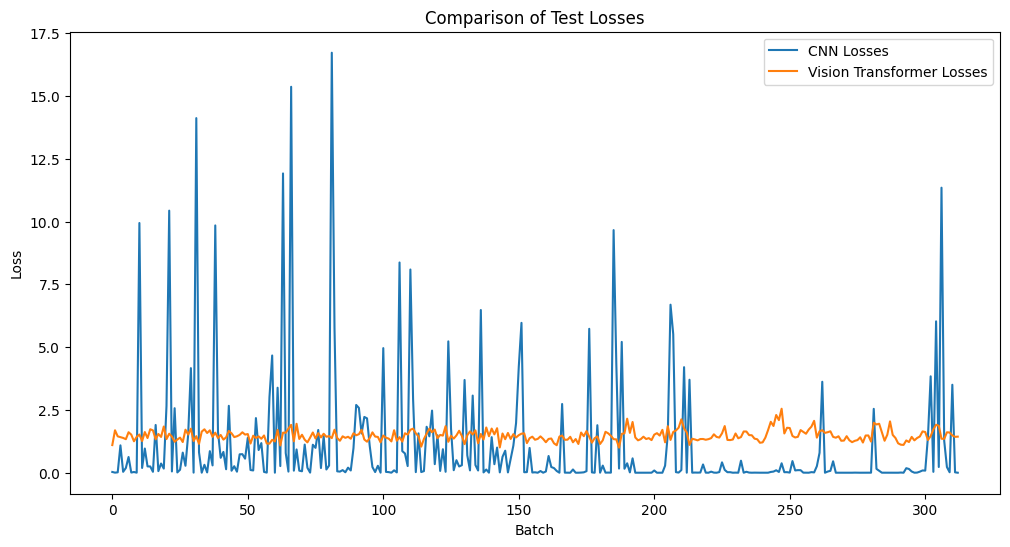

In [ ]:
# Evaluate the CNN
test_losses_cnn, avg_loss_cnn, accuracy_cnn = evaluate_model(cnn_model, device, test_loader_cnn)

plt.figure(figsize=(12, 6))
plt.plot(test_losses_cnn, label='CNN Losses')
plt.plot(vit_losses[:len(test_losses_cnn)], label='Vision Transformer Losses')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Comparison of Test Losses')
plt.legend()
plt.show()

In analyzing the test loss comparison between the CNN and the Vision Transformer, I noticed that my CNN's performance, depicted in blue, was quite erratic, with its loss frequently spiking and dipping, suggesting that at times it was highly accurate, yet at other times it was significantly off. On the other hand, the Vision Transformer, shown in orange, presented a steadier loss pattern, not achieving as low values as the CNN's best but avoiding the high loss peaks. This tells me that while the CNN had moments of brilliance, it was inconsistent, possibly overfitting to certain test data. The Vision Transformer, though it didn't reach the lowest losses that the CNN achieved, was more reliable across different tests. This insight is crucial for me, as it suggests that the CNN might perform exceptionally well with data similar to its training set, while the Vision Transformer might be a safer bet for consistent performance in varied real-world applications.

# Shifted Patch Tokenizer (SPT)

In [ ]:
# Load MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)  # Training dataset
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)  # Testing dataset

# Determine the computation device based on availability of CUDA (GPU support)
device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available, else CPU

# Configuration parameters for data and model
batch_size = 32         # Number of samples per batch
patch_size = 4          # Size of each image patch
img_w, img_h = np.array(mnist_trainset[1][0]).shape  # Image dimensions from the dataset
block_size = img_w // patch_size * img_h // patch_size  # Total number of patches per image

# Neural network model parameters
n_layer = 6             # Number of layers in the model
n_head = 6              # Number of attention heads
n_embd = 384            # Embedding dimension size
dropout = 0.2           # Dropout rate for regularization

# Input and output configurations
input_size = patch_size * patch_size  # Size of input (flattened patch)
n_classes = 10  # Number of output classes (digits 0-9 for MNIST)

# AdamW optimizer configuration
learning_rate = 5e-4    # Maximum learning rate
max_iters = 10000       # Total number of training iterations
grad_clip = 1.0         # Gradient clipping value (or disable if 0.0)

# Learning rate decay settings
warmup_iters = 1000     # Number of steps for learning rate warmup
lr_decay_iters = max_iters  # Total iterations over which to decay the learning rate
min_lr = 5e-5           # Minimum learning rate after decay

# Logging and evaluation settings
eval_interval = 1000    # Interval for model evaluation
log_interval = 100      # Interval for logging training progress

# (Assuming more code follows for model initialization, training loop, etc.)


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)), # Extract patches
    transforms.Lambda(lambda x: x.contiguous().view(-1, patch_size, patch_size)), # Flatten the patches
])

mnist_trainset.transform = transform
mnist_testset.transform = transform

In [ ]:
class Block(nn.Module):
    def __init__(self, n_embd, n_head, block_size, dropout):
        super().__init__()
        self.ln_1 = nn.LayerNorm(n_embd)  # Layer normalization for the input to the attention layer
        self.attn = MultiheadAttention(n_embd, n_head, block_size, dropout)  # Multi-head self-attention mechanism
        self.ln_2 = nn.LayerNorm(n_embd)  # Layer normalization for the input to the MLP
        self.mlp = MLP(n_embd, dropout)  # Feedforward MLP


    def forward(self, x):
        # Layer Normalization and Self-Attention
        x_attn = self.ln_1(x)  # Normalize the input
        x_attn = self.attn(x_attn) + x  # Apply attention and add the residual connection

        # Layer Normalization and MLP
        x = self.ln_2(x_attn)  # Normalize the output from the attention layer
        x = self.mlp(x) + x_attn  # Apply MLP and add the residual connection
        return x

In [ ]:
class ShiftedPatchDataset(torch.utils.data.Dataset):

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset  # Store the provided MNIST dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):

        # Retrieve image and label from the original MNIST dataset
        image, label = self.mnist_dataset[idx]  # Get image and label at the provided index
        image = np.array(image)  # Convert the PIL image to a numpy array

        # Create shifted versions of the image
        up = np.roll(image, -1, axis=0)  # Shift image up
        down = np.roll(image, 1, axis=0)  # Shift image down
        left = np.roll(image, -1, axis=1)  # Shift image left
        right = np.roll(image, 1, axis=1)  # Shift image right

        # Stack the original and shifted images
        stacked_images = np.stack([image, up, down, left, right], axis=0)

        # Convert the stacked images to a torch tensor and return with the label
        return torch.tensor(stacked_images, dtype=torch.float32), label

In [ ]:
# Initialize the shifted patch dataset
shifted_trainset = ShiftedPatchDataset(mnist_trainset)
shifted_testset = ShiftedPatchDataset(mnist_testset)

# Create data loaders with the shifted dataset
train_loader = DataLoader(dataset=shifted_trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=shifted_testset, batch_size=batch_size, shuffle=False)

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, input_size, n_classes, n_layer, n_embd, n_head, block_size, dropout):
        super().__init__()

        """# TODO TASK 1 #"""
        self.block_size = block_size

        self.block_size = block_size

        # Define the transformer components
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Linear(input_size, n_embd),  # Linear layer for patch embedding
            wpe=nn.Embedding(block_size, n_embd),  # Positional embedding layer
            drop=nn.Dropout(dropout), # Dropout layer
            h=nn.ModuleList([Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)]),  # Transformer blocks
            ln_f=nn.LayerNorm(n_embd),  # Layer normalization
        ))

        # Classifier head
        self.classifier = nn.Linear(n_embd, n_classes)
        # init weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        # Initialize weights
        if isinstance(module, nn.Linear) or isinstance(module, nn.LayerNorm):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x, targets=None):
        device = x.device
        b, t = x.size(0), x.size(1)
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"

        """# TODO TASK 1 #"""
        # Compute patch embeddings and add positional encodings
        x = self.transformer.wte(x)  # Patch embeddings
        pos = torch.arange(t, device=device)  # Position indices
        x = x + self.transformer.wpe(pos)[None, :, :]  # Add positional embeddings
        x = self.transformer.drop(x)  # Apply dropout

        # Pass through each transformer block
        for block in self.transformer.h:
            x = block(x)

        # Apply final layer normalization
        x = self.transformer.ln_f(x)

        # Classifier head
        # Mean pooling is used before the classification layer
        logits = self.classifier(x.mean(dim=1))  # Using mean pooling here

        # Compute loss if targets are provided
        loss = F.cross_entropy(logits, targets) if targets is not None else None
        return logits, loss


In [ ]:
# Print the device being used (e.g., CPU or GPU)
print(device)

# Initialize the Vision Transformer model with specified parameters
model = VisionTransformer(input_size, n_classes, n_layer, n_embd, n_head, block_size, dropout)

# Move the model to the specified device (GPU or CPU)
model.to(device)

# Define the optimizer, here AdamW, with model parameters and learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Initialize iteration counter, test losses list, and accuracy list
iter_counter = 0
test_losses_vit3 = []
accuracy_vit3 = []

# Calculate the number of batches in the train and test loaders
train_loader_size = len(train_loader)
test_loader_size = len(test_loader)

# Training loop that runs until the maximum number of iterations is reached
while iter_counter < max_iters:
    # Set the model to training mode
    model.train()

    # Initialize variables for tracking loss and accuracy
    total_loss = 0.0
    correct = 0
    total = 0

    # Iterate over each batch in the training data loader
    for batch_idx, (data, target) in enumerate(train_loader):
        # Reshape data and move it to the device
        data = data.view(-1, block_size, patch_size * patch_size).to(device)
        # Repeat target to match the data size and move it to the device
        target = target.repeat_interleave(5).to(device)

        # Forward pass: Compute predicted output and loss
        logits, loss = model(data, target)

        # Zero the gradients before backward pass
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Get the index of the max log-probability as the predicted label
        predicted = torch.argmax(logits, dim=-1)
        # Update the total number of samples processed
        total += target.size(0)
        # Update the total number of correctly predicted samples
        correct += (predicted == target).sum().item()
        # Update the total loss
        total_loss += loss.item()
        # Increment iteration counter
        iter_counter += 1

        # Logging interval: print average loss and accuracy for the interval
        if iter_counter % log_interval == 0:
            avg_loss = total_loss / log_interval
            accuracy = correct / total
            print(f'Iter [{iter_counter}/{max_iters}], Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')
            # Reset loss, correct, and total for the next interval
            total_loss = 0.0
            correct = 0
            total = 0

        # Evaluation interval: evaluate the model on the test dataset
        if iter_counter % eval_interval == 0 or iter_counter == max_iters:
            # Set the model to evaluation mode
            model.eval()
            # Initialize variables for tracking test loss and accuracy
            test_loss = 0.0
            test_correct = 0
            test_total = 0

            # Disable gradient computation for evaluation
            with torch.no_grad():
                # Iterate over each batch in the test data loader
                for test_data, test_target in test_loader:
                    # Reshape test data and move it to the device
                    test_data = test_data.view(-1, block_size, patch_size * patch_size).to(device)
                    # Repeat test target to match the data size and move it to the device
                    test_target = test_target.repeat_interleave(5).to(device)

                    # Forward pass: Compute predicted output and loss for test data
                    test_outputs, loss = model(test_data, test_target)
                    # Update the test loss
                    test_loss += loss.item()
                    # Append the individual loss of this batch to the list
                    test_losses_vit3.append(loss.item())

                    # Get the predicted labels for the test data
                    test_predicted = torch.argmax(test_outputs, dim=-1)
                    # Update the total number of test samples processed
                    test_total += test_target.size(0)
                    # Update the total number of correctly predicted test samples
                    test_correct += (test_predicted == test_target).sum().item()

            # Calculate average test loss and accuracy
            avg_test_loss = test_loss / test_loader_size
            test_accuracy = test_correct / test_total
            # Append the accuracy of this evaluation to the list
            accuracy_vit3.append(test_accuracy)
            # Log the test loss and accuracy
            print(f'Iter [{iter_counter}/{max


plt.style.use('ggplot')

# Plot each set of data with custom line styles and markers
plt.plot(accuracy_vit, label='Vision Transformer', color='blue', linestyle='-', marker='o')
plt.plot(accuracy_vit2, label='Local Transformer', color='green', linestyle='--', marker='x')
plt.plot(accuracy_vit3, label='Shifted Patch Tokenizer', color='red', linestyle='-.', marker='^')
# Adding a legend
plt.legend()

plt.title('Epoch-Wise Accuracy Comparison of Transformer Models')
plt.xlabel('Epoch Number')
plt.ylabel('Model Accuracy (%)')

# Optionally, add gridlines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

SyntaxError: unterminated string literal (detected at line 110) (2985532338.py, line 110)